# One Pixel Attack Tutorial

![](images/pred2.png "All it takes is one pixel")

This notebook will demonstrate the one pixel attack with a few different convolutional neural network models. By using differential evolution, we find a special pixel that can modify a target image such that the network misclassifies the image (which it previously correctly classified).

In theory, we want models that don't get fooled by such tiny changes. Especially in images, it is undesirable to have a small alteration in the input result in a drastic change in the output. However, even the most accurate neural networks are susceptible to this type of attack.

Let's get started.

## Imports

Ensure that you have `numpy`, `pandas`, `scipy`, `matplotlib`, `tensorflow-gpu`, and `keras` installed.

In [1]:
# Python Libraries
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import matplotlib
from keras.datasets import cifar10

# Custom Networks
from networks.lecun_net import LecunNet
from networks.pure_cnn import PureCnn
from networks.network_in_network import NetworkInNetwork
from networks.resnet import ResNet
from networks.densenet import DenseNet
from networks.wide_resnet import WideResNet
from networks.capsnet import CapsNet

# Helper functions
from differential_evolution import differential_evolution
import helper

matplotlib.style.use('ggplot')
np.random.seed = 100

from time import time

/home/shanicky/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load Dataset

For this attack, we will use the [Cifar10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) packaged by Keras. The task of the dataset is to correctly classify a 32x32 pixel image in 1 of 10 categories (e.g., bird, deer, truck).

The code below will load the Cifar10 dataset. Keras will need to download the dataset if it is not cached locally already.

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

We can access and display any image in the dataset by its index. For instance, here is a horse.

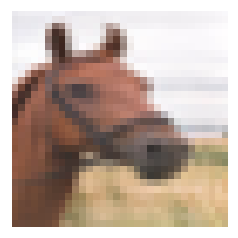

In [4]:
image = 99 # Image index in the test set
helper.plot_image(x_test[image])

## Image Perturbation

To begin, we need a function to modify one or more pixels in an image. 

We can define the perturbation of a pixel as a 5-tuple 

$$\textbf{x} = (x, y, r, g, b)$$

where $x, y$ are the coordinates of the pixel from 0 to 31, and $r,g,b$ are the red, green, and blue values from 0 to 255. Then multiple perturbations can simply be a concatenation of these tuples:

$$X = (x_1, y_1, r_1, g_1, b_1, x_2, y_2, r_2, g_2, b_2, ...)$$

We could instead use an array of tuples, but the optimization algorithm we will use requires it to be a flat 1-d vector.

Then the function to perturb an image can take as an input the image and $X$, and output a copy of the image with each pixel at $x_i, y_i$ modified to have the color $r_i, g_i, b_i$. To speed up computation, we will batch together an array of $X$ perturbations, denoted $X_S$.

In [5]:
def perturb_image(xs, img):
    # If this function is passed just one perturbation vector,
    # pack it in a list to keep the computation the same
    if xs.ndim < 2:
        xs = np.array([xs])
    
    # Copy the image n == len(xs) times so that we can 
    # create n new perturbed images
    tile = [len(xs)] + [1]*(xs.ndim+1)
    imgs = np.tile(img, tile)
    
    # Make sure to floor the members of xs as int types
    xs = xs.astype(int)
    
    for x,img in zip(xs, imgs):
        # Split x into an array of 5-tuples (perturbation pixels)
        # i.e., [[x,y,r,g,b], ...]
        pixels = np.split(x, len(x) // 5)
        for pixel in pixels:
            # At each pixel's x,y position, assign its rgb value
            x_pos, y_pos, *rgb = pixel
            img[x_pos, y_pos] = rgb
    
    return imgs

Now we can modify the pixels of any image we want.

Let's modify our horse image by making pixel (16,16) yellow.

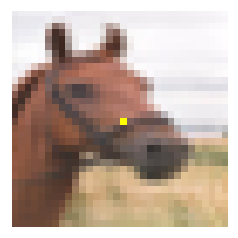

In [6]:
image = 99 # Image index in the test set
pixel = np.array([16, 16, 255, 255, 0]) # pixel = x,y,r,g,b
image_perturbed = perturb_image(pixel, x_test[image])[0]

helper.plot_image(image_perturbed)

## Load Models

To demonstrate the attack, we need some neural network models trained on the Cifar10 dataset. We will now load some pretrained models, which can be found in the `networks/models` directory.

It is recommended to use Keras with a GPU enabled. The code below can be used to check (if using TensorFlow).

In [7]:
# Should output /device:GPU:0
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

There are two models included in this repository, `lecun_net` and `resnet` which will be loaded from disk automatically.

Optionally, you may [download the larger, more accurate models](https://www.dropbox.com/sh/dvatkpjl0sn79kn/AAC9L4puJ_sdFUkDZfr5SFkLa?dl=0) (e.g., Capsule Network, DenseNet, etc.). Make sure to copy the models into the `networks/models/` directory. Then uncomment the lines below and run the cell to load the models of your choosing.

In [8]:
lecun_net = LecunNet()
resnet = ResNet()

models = [lecun_net, resnet]

## Uncomment below to load more models to play with. Make sure the model files exist by training or downloading them.

# lecun_net = LecunNet()
# pure_cnn = PureCnn()
# net_in_net = NetworkInNetwork()
# resnet = ResNet()
# densenet = DenseNet()
# wide_resnet = WideResNet()
# capsnet = CapsNet()

# models = [lecun_net, pure_cnn, net_in_net, resnet, densenet, wide_resnet, capsnet]

Successfully loaded lecun_net
Successfully loaded resnet


Note that there are even more networks available in the `networks` directory, but must be trained before loading them here.

### Calculate Model Accuracies

After loading the models, we would like to evaluate all test images with each model to ensure that we only attack the images which have been classified correctly. The code below will also display the accuracy and number of parameters of each model.

In [9]:
network_stats, correct_imgs = helper.evaluate_models(models, x_test, y_test)
correct_imgs = pd.DataFrame(correct_imgs, columns=['name', 'img', 'label', 'confidence', 'pred'])
network_stats = pd.DataFrame(network_stats, columns=['name', 'accuracy', 'param_count'])

network_stats

Evaluating lecun_net
Evaluating resnet


,name,accuracy,param_count
0,lecun_net,0.7488,62006
1,resnet,0.9231,470218


### Prediction Function

For the black-box attack, all we should care about is the inputs to the model (the images), and the outputs of the model (the prediction probabilities). No special information about the model is required; we could even swap it with a model that is not a neural network.

Define a function that runs several perturbed images on a given model and returns the model's confidence (probability output) in the target class, one confidence value per image. If the target class is the correct class, this will be the function that we want to minimize so that the model will be most confident in another class (which is incorrect). Otherwise, the target is an incorrect class and we will want to maximize it.

In [10]:
def predict_classes(xs, img, target_class, model, minimize=True):
    # Perturb the image with the given pixel(s) x and get the prediction of the model
    imgs_perturbed = perturb_image(xs, img)
    predictions = model.predict(imgs_perturbed)[:,target_class]
    # This function should always be minimized, so return its complement if needed
    return predictions if minimize else 1 - predictions

Below we can modify a pixel in an image and see how the confidence of the model changes. In almost all cases, the confidence will not change. However, for very special cases it will change drastically.

Confidence in true class bird is 0.00018887498
Prior confidence was 0.70661867


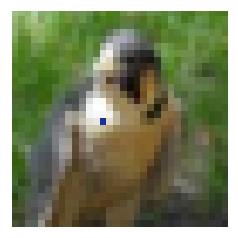

In [11]:
image = 384
pixel = np.array([16, 13,  25, 48, 156])
model = resnet

true_class = y_test[image,0]
prior_confidence = model.predict_one(x_test[image])[true_class]
confidence = predict_classes(pixel, x_test[image], true_class, model)[0]

print('Confidence in true class', class_names[true_class], 'is', confidence)
print('Prior confidence was', prior_confidence)
helper.plot_image(perturb_image(pixel, x_test[image])[0])

## The Attack

Here we will demonstrate two variants of the one pixel attack: untargeted and targeted.

### Targeted vs. Untargeted Attacks

The objective of an untargeted attack is to cause a model to misclassify an image. This means we want to perturb an image as to minimize the confidence probability of the correct classification category and maximize the sum of the probabilities of all other categories.

The objective of a targeted attack is to cause a model to classify an image as a given  target class. We want to perturb an image as to maximize the probability of a class of our own choosing.

### Success Criterion

Define a function so that whenever a given perturbation is sufficient to fool a model, it returns `True`. This will be called the success criterion. The `targeted_attack` boolean flag will indicate whether success means maximization of the target class or minimization of the correct (target) class.

In [12]:
def attack_success(x, img, target_class, model, targeted_attack=False, verbose=False):
    # Perturb the image with the given pixel(s) and get the prediction of the model
    attack_image = perturb_image(x, x_test[img])[0]

    confidence = model.predict_one(attack_image)
    predicted_class = np.argmax(confidence)
    
    # If the prediction is what we want (misclassification or 
    # targeted classification), return True
    if (verbose):
        print('Confidence:', confidence[target_class])
    if ((targeted_attack and predicted_class == target_class) or
        (not targeted_attack and predicted_class != target_class)):
        return True

Here we demonstrate the usage of the success criterion function. It's nearly identical to `predict_class()` as before, but also decides the success of the attack. For purposes of demonstration we assume an untargeted attack.

Confidence: 0.074600935
Prior confidence 0.50054246
Attack success: True


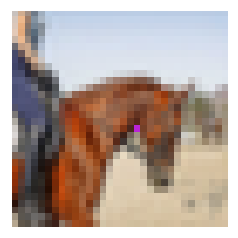

In [13]:
image = 541
pixel = np.array([17, 18, 185, 36, 215])
model = resnet

true_class = y_test[image,0]
prior_confidence = model.predict_one(x_test[image])[true_class]
success = attack_success(pixel, image, true_class, model, verbose=True)

print('Prior confidence', prior_confidence)
print('Attack success:', success == True)
helper.plot_image(perturb_image(pixel, x_test[image])[0])

### Attack Function

Finally, we arrive at the attack itself: how do we find the pixels that will result in a successful attack? First, formulate it as an optimization problem: in an untargeted attack, minimize the confidence of the correct class, and in a targeted attack, maximize the confidence of a target class. This is precisely our `predict_class` function.

When performing black-box optimizations such as the one pixel attack, it can be very difficult to find an efficient gradient-based optimization that will work for the problem. It would be nice to use an optimization algorithm that can find good solutions without relying on the smoothness of the function. In our case, we have discrete integer positions ranging from 0 to 31 and color intensities from 0 to 255, so the function is expected to be jagged.

For that, we use an algorithm called [differential evolution](https://en.wikipedia.org/wiki/Differential_evolution). Here's an example of differential evolution optimizing the [Ackley function](https://en.wikipedia.org/wiki/Ackley_function):

<br>

![Ackley GIF](images/Ackley.gif)

<br>

Differential evolution is a type of evolutionary algorithm where a population of candidate solutions generate offspring which compete with the rest of the population each generation according to their fitness. Each candidate solution is represented by a vector of real numbers which are the inputs to the function we would like to minimize. The lower the output of this function, the better the fitness. The algorithm works by initializing a (usually random) population of vectors, generating new offspring vectors by combining (mutating) individuals in the population, and replacing worse-performing individuals with better candidates.

In the context of the one pixel attack, our input will be a flat vector of pixel values:

$$X = (x_1, y_1, r_1, g_1, b_1, x_2, y_2, r_2, g_2, b_2, ...)$$

These will be encoded as floating-point values, but will be floored back into integers to calculate image perturbations. First we generate a random population of $n$ perturbations

$$\textbf{P} = (X_1, X_2, \dots, X_n)$$

Then, on each iteration we calculate $n$ new mutant children using the formula

$$X_i = X_{r1} + F (X_{r2} - X_{r3})$$

such that

$$r1 \neq r2 \neq r3$$

where $r1,r2,r3$ are random indices into our population $\textbf{P}$, and $F = 0.5$ is a mutation parameter. Basically, we pick 3 random individuals from the previous generation and recombine them to make a new candidate solution. If this candidate $X_i$ gives a lower minimum at position $i$ (i.e., the attack is closer to success), replace the old $X_i$ with this new one. This process repeats for several iterations until our stopping criterion, `attack_success`, which is when we find an image that successfully completes the attack.

<br>

See [this excellent tutorial post](https://pablormier.github.io/2017/09/05/a-tutorial-on-differential-evolution-with-python/) on how differential evolution works in greater detail. 

We will use a [slight modification](differential_evolution.py) of [Scipy's implementation of differential evolution](https://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.optimize.differential_evolution.html).


In [14]:
def attack(img, model, target=None, pixel_count=1, 
           maxiter=75, popsize=400, verbose=False):
    # Change the target class based on whether this is a targeted attack or not
    targeted_attack = target is not None
    target_class = target if targeted_attack else y_test[img,0]
    
    # Define bounds for a flat vector of x,y,r,g,b values
    # For more pixels, repeat this layout
    bounds = [(0,32), (0,32), (0,256), (0,256), (0,256)] * pixel_count
    
    # Population multiplier, in terms of the size of the perturbation vector x
    popmul = max(1, popsize // len(bounds))
    
    # Format the predict/callback functions for the differential evolution algorithm
    predict_fn = lambda xs: predict_classes(
        xs, x_test[img], target_class, model, target is None)
    callback_fn = lambda x, convergence: attack_success(
        x, img, target_class, model, targeted_attack, verbose)
    
    # Call Scipy's Implementation of Differential Evolution
    attack_result = differential_evolution(
        predict_fn, bounds, maxiter=maxiter, popsize=popmul,
        recombination=1, atol=-1, callback=callback_fn, polish=False)

    # Calculate some useful statistics to return from this function
    attack_image = perturb_image(attack_result.x, x_test[img])[0]
    prior_probs = model.predict_one(x_test[img])
    predicted_probs = model.predict_one(attack_image)
    predicted_class = np.argmax(predicted_probs)
    actual_class = y_test[img,0]
    success = predicted_class != actual_class
    cdiff = prior_probs[actual_class] - predicted_probs[actual_class]

    # Show the best attempt at a solution (successful or not)
    helper.plot_image(attack_image, actual_class, class_names, predicted_class)

    return [model.name, pixel_count, img, actual_class, predicted_class, success, cdiff, prior_probs, predicted_probs, attack_result.x]

#### Untargeted Attack

Let's look at one iteration of the untargeted attack. Here we will demonstrate a successful attack an image of a frog with the `resnet` model. We should see the confidence in the true class drop after several iterations.

Try to see if you can successfully attack other images/models. The more pixels we are allowed to modify, the more likely it is we are to find a solution for any given image.

Confidence: 0.9733599
Confidence: 0.9733599
Confidence: 0.9733599
Confidence: 0.84847265
Confidence: 0.84847265
Confidence: 0.84847265
Confidence: 0.77187806
Confidence: 0.6017658
Confidence: 0.6017658
Confidence: 0.6017658
Confidence: 0.4942157


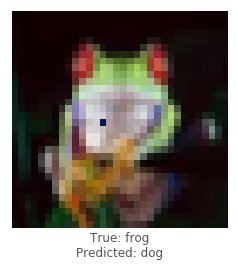

In [15]:
image = 102
pixels = 1 # Number of pixels to attack
model = resnet

_ = attack(image, model, pixel_count=pixels, verbose=True)

#### Targeted Attack

In the targeted attack, we can choose which class we want a model to classify an image as. The task is much harder for the targeted attack, as we constrain the misclassification to a given class rather than any class that's not the correct one. We should see the confidence in the target class rise after several iterations.

Below we try to cause the `lecun_net` to classify an image of a `ship` as an `automobile`. Try to change the parameters and see what happens.

Attacking with target automobile
Confidence: 0.029140746
Confidence: 0.029140746
Confidence: 0.06275176
Confidence: 0.066548206
Confidence: 0.07828403
Confidence: 0.07828403
Confidence: 0.07828403
Confidence: 0.07828403
Confidence: 0.16095972
Confidence: 0.16095972
Confidence: 0.16095972
Confidence: 0.16095972
Confidence: 0.16095972
Confidence: 0.16095972
Confidence: 0.26772958
Confidence: 0.26772958
Confidence: 0.26772958
Confidence: 0.33424166
Confidence: 0.34620786
Confidence: 0.3869161
Confidence: 0.3869161
Confidence: 0.3869161
Confidence: 0.3869161
Confidence: 0.3869161
Confidence: 0.52665144


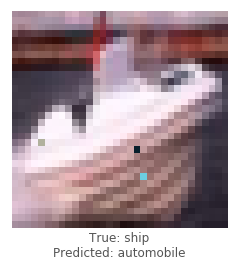

In [16]:
image = 108
target_class = 1 # Integer in range 0-9
pixels = 3
model = lecun_net

print('Attacking with target', class_names[target_class])
_ = attack(image, model, target_class, pixel_count=pixels, verbose=True)

### Collect Results

Armed with all the necessary tools to conduct a one pixel attack, the final step is to collect relevant statistics on the targeted and untargeted attack. The relevant data points are what percentage of images were we able to successfully attack for a given model, and how the number of pixels affect this percentage.

We will loop through every combination of all models, perturbations of 1,3,5 pixels, images, and target classes (for the targeted attack). This will take a lot of computational resources and time, so [skip to the statistics section](#Attack-Statistics) if that's not your idea of fun.

In [17]:
def attack_all(models, samples=500, pixels=[1], targeted=False, 
               maxiter=75, popsize=400, verbose=False):
    results = []
    for model in models:
        model_results = []
        valid_imgs = correct_imgs[correct_imgs.name == model.name].img
        img_samples = np.random.choice(valid_imgs, samples)
        
        for pixel_count in pixels:
            for i,img in enumerate(img_samples):
                print(model.name, '- image', img, '-', i+1, '/', len(img_samples))
                targets = [None] if not targeted else range(10)
                
                for target in targets:
                    if (targeted):
                        print('Attacking with target', class_names[target])
                        if (target == y_test[img,0]):
                            continue
                    result = attack(img, model, target, pixel_count, 
                                    maxiter=maxiter, popsize=popsize, 
                                    verbose=verbose)
                    model_results.append(result)
                    
        results += model_results
        helper.checkpoint(results, targeted)
    return results

lecun_net - image 4547 - 1 / 100


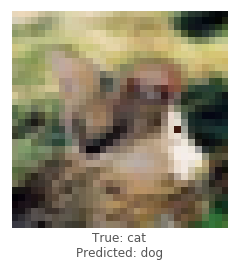

lecun_net - image 6061 - 2 / 100


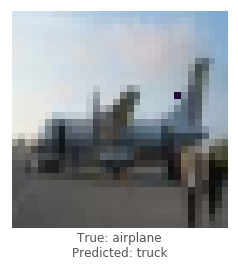

lecun_net - image 976 - 3 / 100


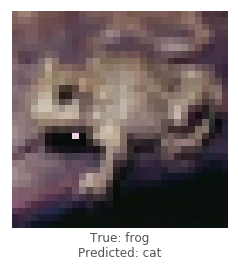

lecun_net - image 9238 - 4 / 100


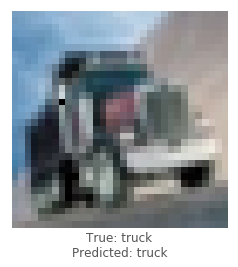

lecun_net - image 7164 - 5 / 100


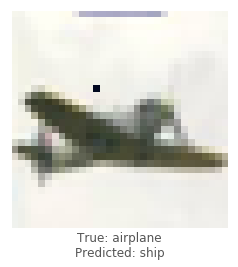

lecun_net - image 992 - 6 / 100


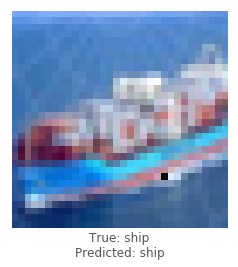

lecun_net - image 2038 - 7 / 100


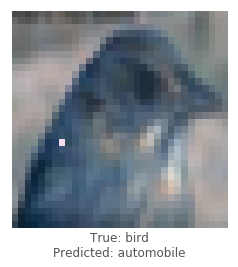

lecun_net - image 6220 - 8 / 100


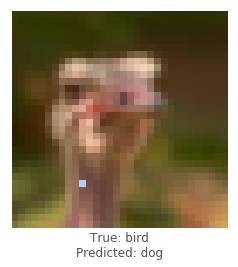

lecun_net - image 754 - 9 / 100


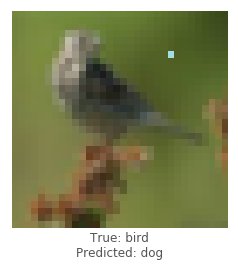

lecun_net - image 3812 - 10 / 100


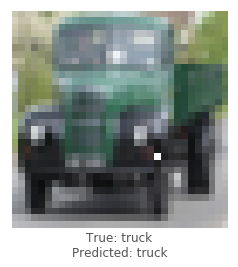

lecun_net - image 7920 - 11 / 100


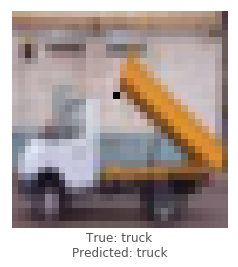

lecun_net - image 3418 - 12 / 100


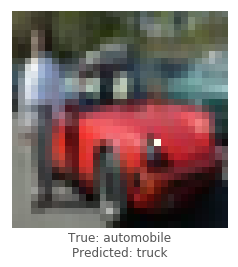

lecun_net - image 4559 - 13 / 100


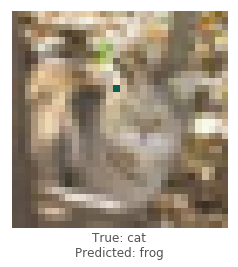

lecun_net - image 2202 - 14 / 100


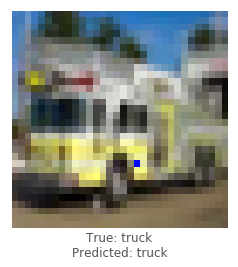

lecun_net - image 2268 - 15 / 100


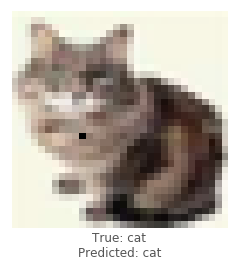

lecun_net - image 9572 - 16 / 100


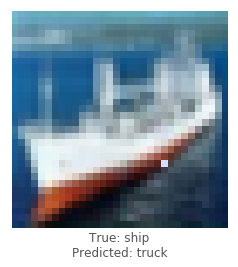

lecun_net - image 2493 - 17 / 100


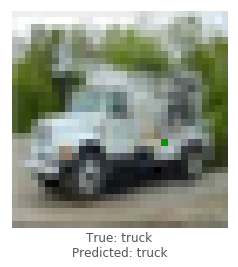

lecun_net - image 5016 - 18 / 100


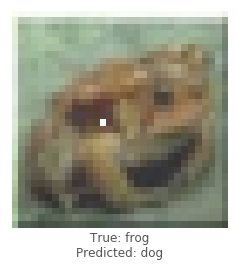

lecun_net - image 6943 - 19 / 100


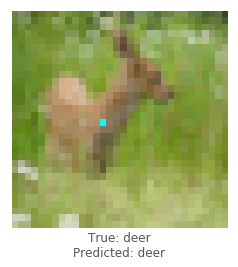

lecun_net - image 3916 - 20 / 100


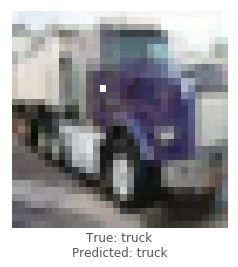

lecun_net - image 6990 - 21 / 100


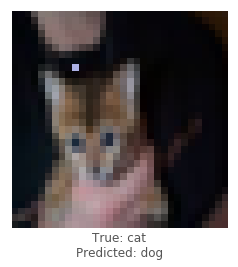

lecun_net - image 5206 - 22 / 100


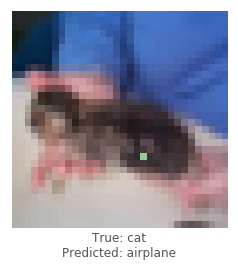

lecun_net - image 9066 - 23 / 100


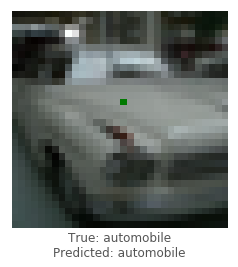

lecun_net - image 8534 - 24 / 100


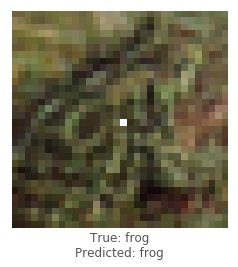

lecun_net - image 6205 - 25 / 100


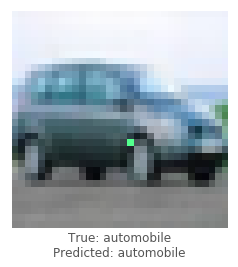

lecun_net - image 4770 - 26 / 100


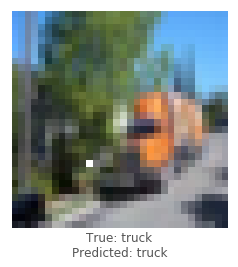

lecun_net - image 512 - 27 / 100


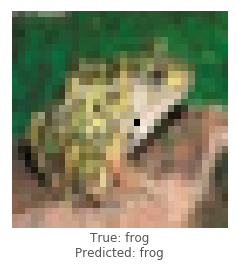

lecun_net - image 2213 - 28 / 100


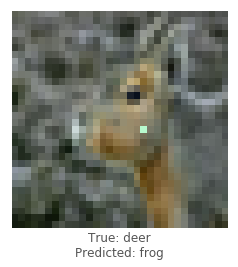

lecun_net - image 1859 - 29 / 100


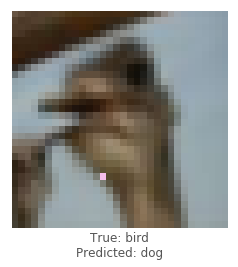

lecun_net - image 4882 - 30 / 100


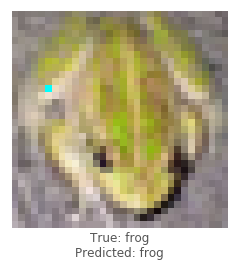

lecun_net - image 2990 - 31 / 100


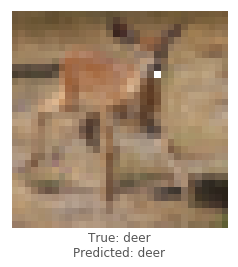

lecun_net - image 9710 - 32 / 100


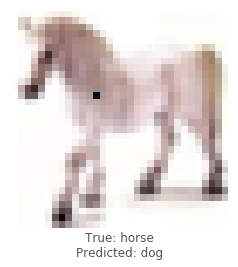

lecun_net - image 6457 - 33 / 100


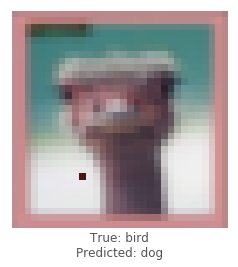

lecun_net - image 3699 - 34 / 100


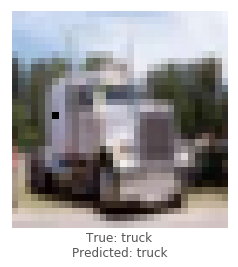

lecun_net - image 9292 - 35 / 100


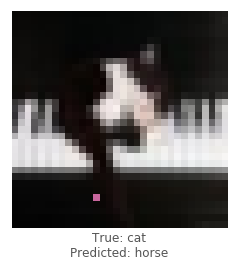

lecun_net - image 7828 - 36 / 100


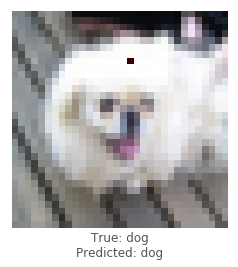

lecun_net - image 964 - 37 / 100


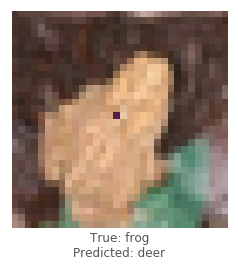

lecun_net - image 4596 - 38 / 100


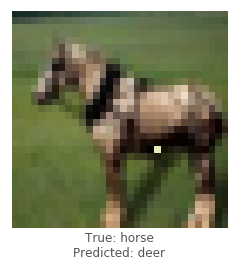

lecun_net - image 2206 - 39 / 100


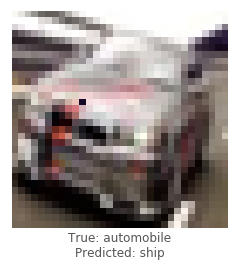

lecun_net - image 3109 - 40 / 100


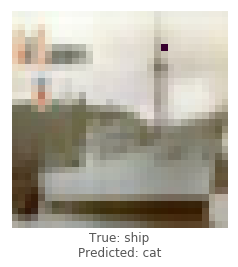

lecun_net - image 3663 - 41 / 100


/media/shanicky/HDD/code/one-pixel-attack-keras/differential_evolution.py:584: RuntimeWarning: divide by zero encountered in double_scalars
  convergence=self.tol / convergence) is True):


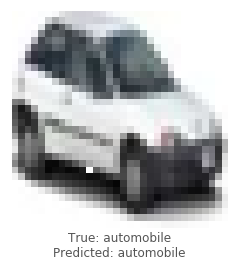

lecun_net - image 4506 - 42 / 100


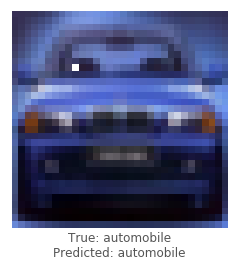

lecun_net - image 4853 - 43 / 100


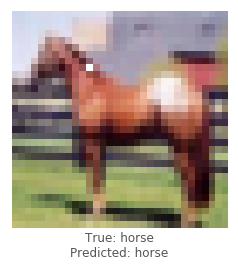

lecun_net - image 165 - 44 / 100


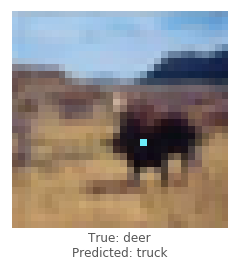

lecun_net - image 8201 - 45 / 100


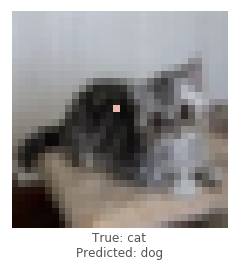

lecun_net - image 4381 - 46 / 100


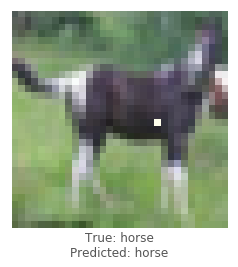

lecun_net - image 6796 - 47 / 100


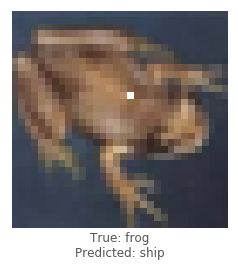

lecun_net - image 1196 - 48 / 100


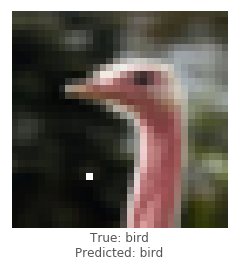

lecun_net - image 6013 - 49 / 100


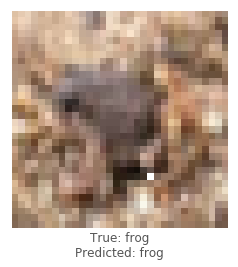

lecun_net - image 3199 - 50 / 100


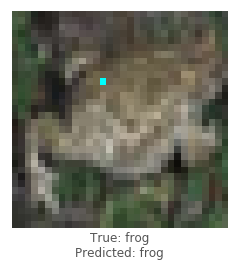

lecun_net - image 3785 - 51 / 100


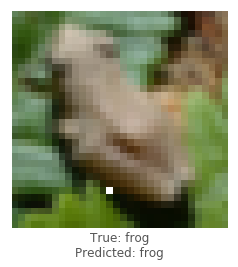

lecun_net - image 6954 - 52 / 100


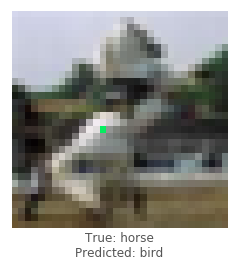

lecun_net - image 5586 - 53 / 100


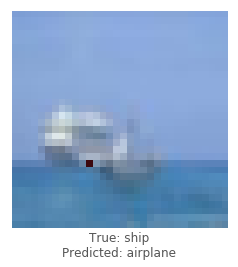

lecun_net - image 6468 - 54 / 100


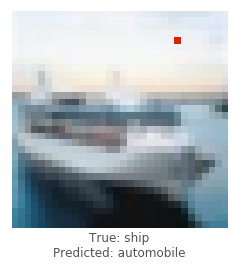

lecun_net - image 1397 - 55 / 100


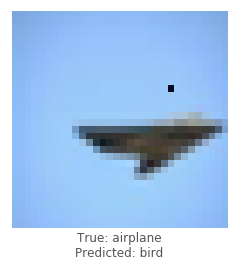

lecun_net - image 3305 - 56 / 100


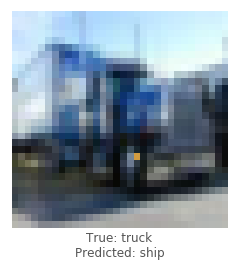

lecun_net - image 8108 - 57 / 100


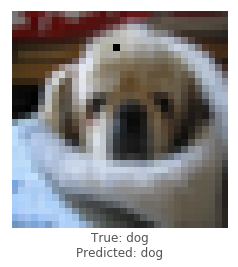

lecun_net - image 7148 - 58 / 100


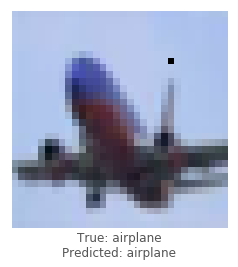

lecun_net - image 5824 - 59 / 100


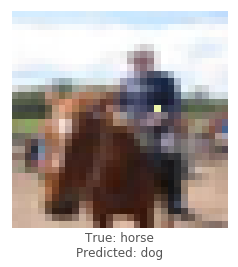

lecun_net - image 2164 - 60 / 100


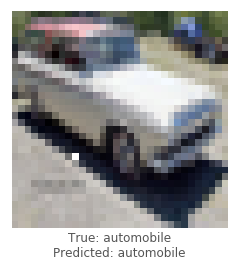

lecun_net - image 6874 - 61 / 100


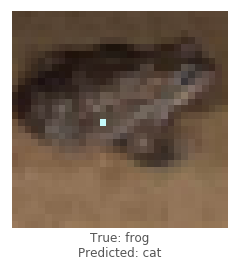

lecun_net - image 7138 - 62 / 100


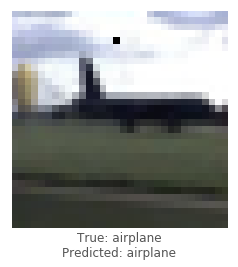

lecun_net - image 5658 - 63 / 100


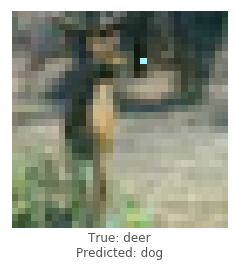

lecun_net - image 4715 - 64 / 100


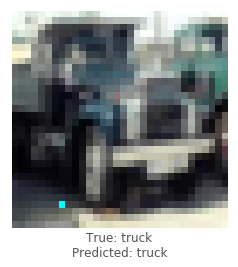

lecun_net - image 3777 - 65 / 100


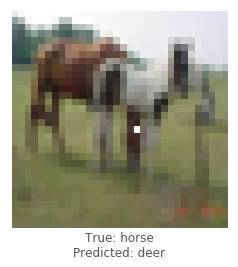

lecun_net - image 1631 - 66 / 100


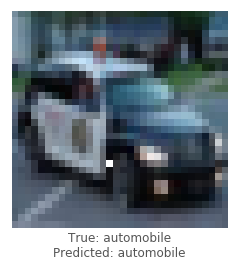

lecun_net - image 5944 - 67 / 100


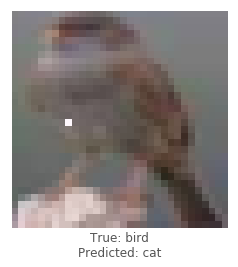

lecun_net - image 958 - 68 / 100


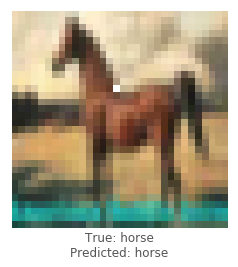

lecun_net - image 5725 - 69 / 100


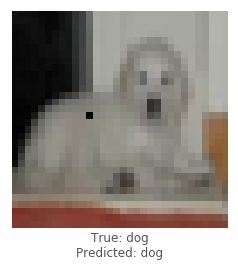

lecun_net - image 9536 - 70 / 100


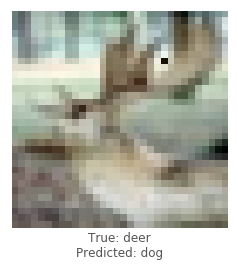

lecun_net - image 3195 - 71 / 100


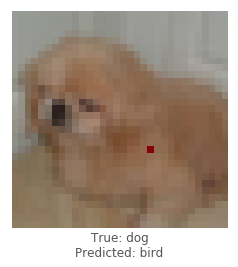

lecun_net - image 6742 - 72 / 100


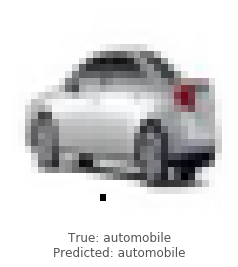

lecun_net - image 1343 - 73 / 100


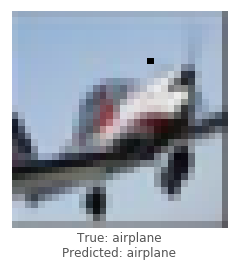

lecun_net - image 2633 - 74 / 100


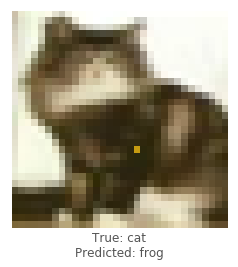

lecun_net - image 5545 - 75 / 100


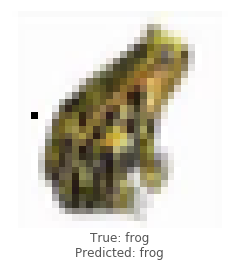

lecun_net - image 7157 - 76 / 100


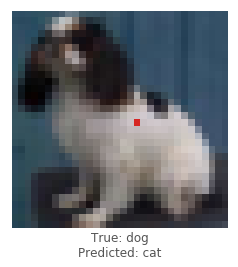

lecun_net - image 6804 - 77 / 100


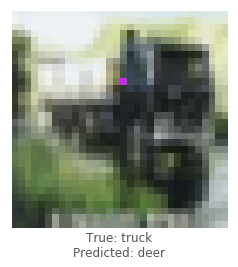

lecun_net - image 2846 - 78 / 100


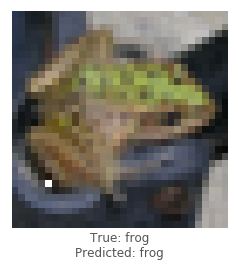

lecun_net - image 6135 - 79 / 100


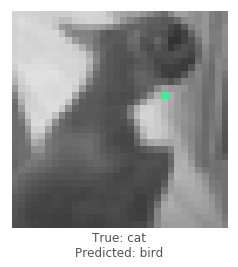

lecun_net - image 112 - 80 / 100


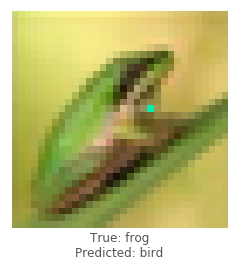

lecun_net - image 1233 - 81 / 100


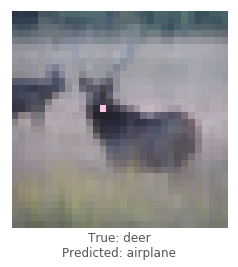

lecun_net - image 5316 - 82 / 100


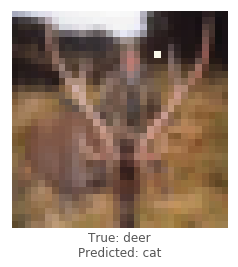

lecun_net - image 1249 - 83 / 100


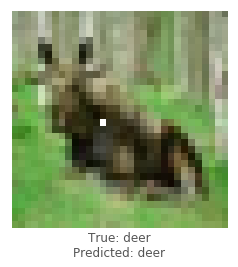

lecun_net - image 3862 - 84 / 100


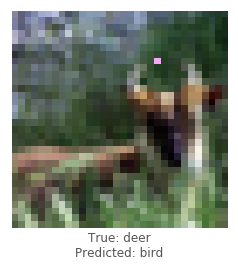

lecun_net - image 8329 - 85 / 100


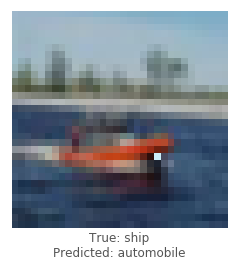

lecun_net - image 9658 - 86 / 100


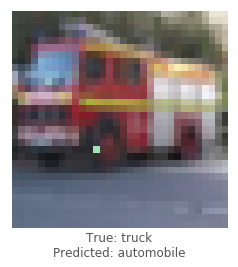

lecun_net - image 8363 - 87 / 100


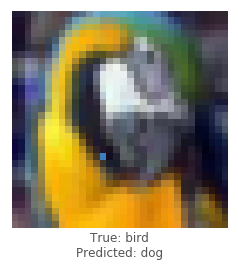

lecun_net - image 293 - 88 / 100


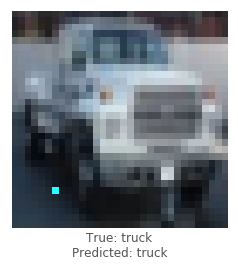

lecun_net - image 4959 - 89 / 100


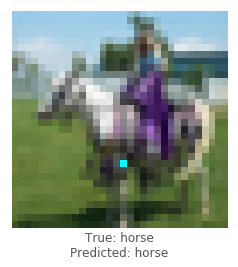

lecun_net - image 5974 - 90 / 100


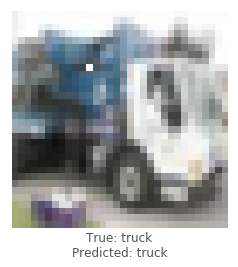

lecun_net - image 9451 - 91 / 100


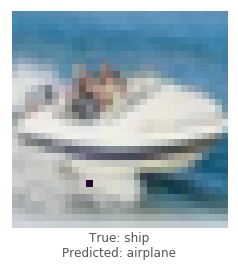

lecun_net - image 7712 - 92 / 100


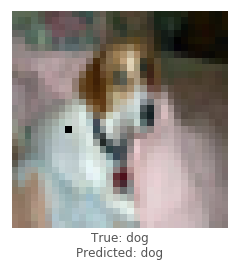

lecun_net - image 5285 - 93 / 100


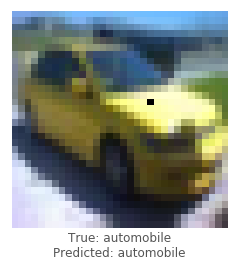

lecun_net - image 1555 - 94 / 100


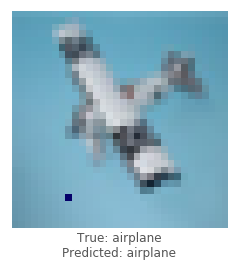

lecun_net - image 2850 - 95 / 100


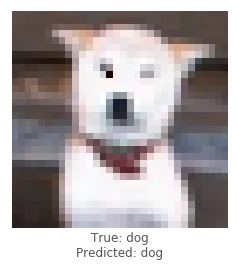

lecun_net - image 5636 - 96 / 100


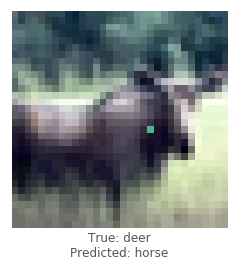

lecun_net - image 4616 - 97 / 100


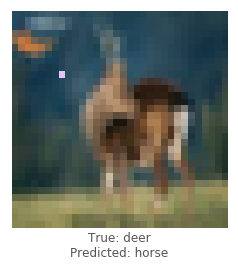

lecun_net - image 8165 - 98 / 100


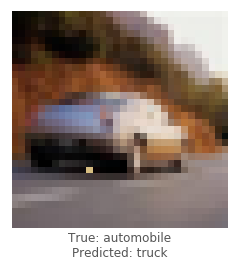

lecun_net - image 8948 - 99 / 100


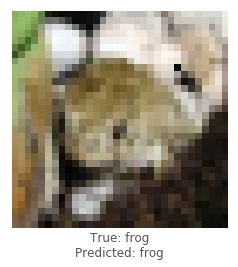

lecun_net - image 1463 - 100 / 100


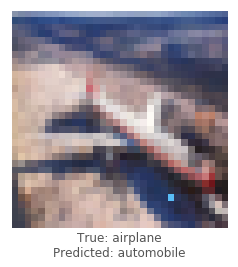

resnet - image 6450 - 1 / 100


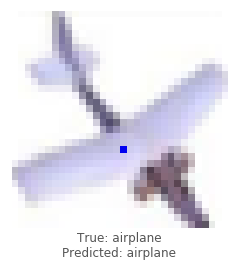

resnet - image 7771 - 2 / 100


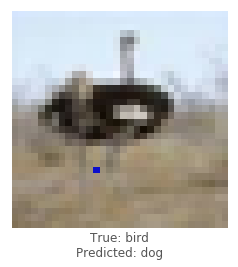

resnet - image 1346 - 3 / 100


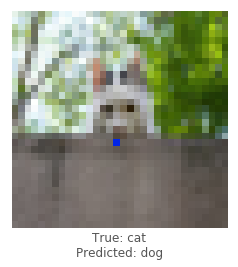

resnet - image 6221 - 4 / 100


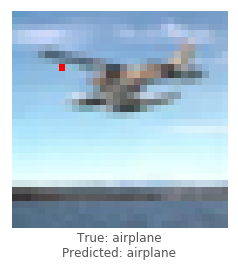

resnet - image 8755 - 5 / 100


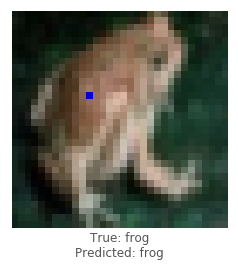

resnet - image 5530 - 6 / 100


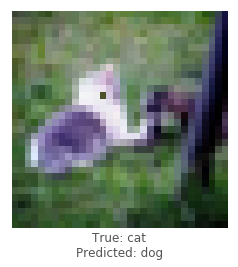

resnet - image 7367 - 7 / 100


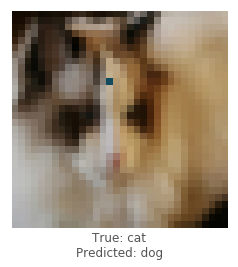

resnet - image 5683 - 8 / 100


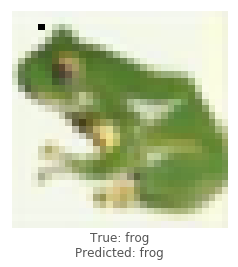

resnet - image 8407 - 9 / 100


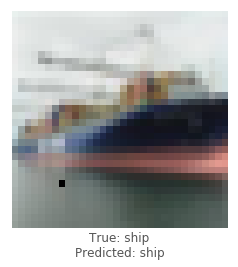

resnet - image 5967 - 10 / 100


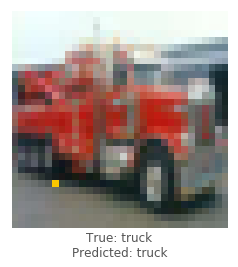

resnet - image 7971 - 11 / 100


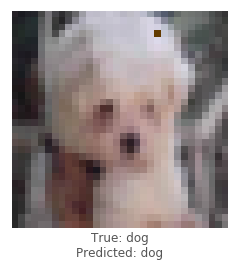

resnet - image 4822 - 12 / 100


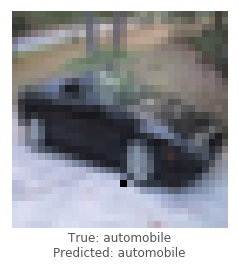

resnet - image 6603 - 13 / 100


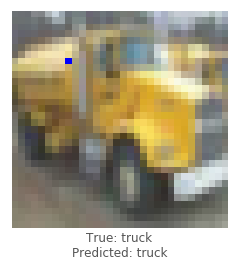

resnet - image 7786 - 14 / 100


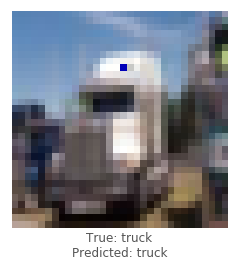

resnet - image 5066 - 15 / 100


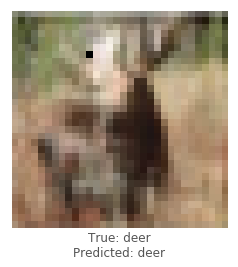

resnet - image 4082 - 16 / 100


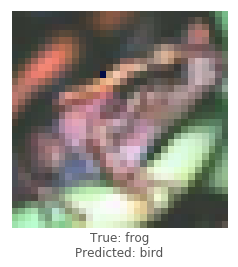

resnet - image 7583 - 17 / 100


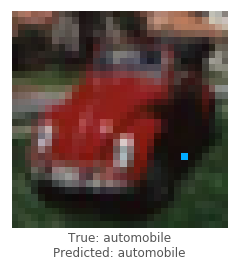

resnet - image 5944 - 18 / 100


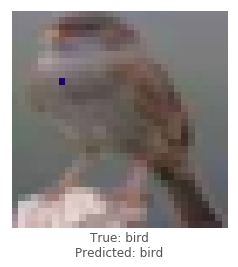

resnet - image 5181 - 19 / 100


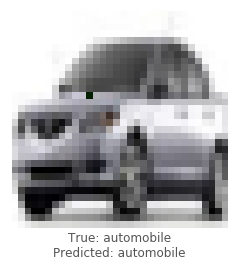

resnet - image 1295 - 20 / 100


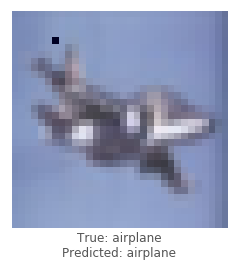

resnet - image 4948 - 21 / 100


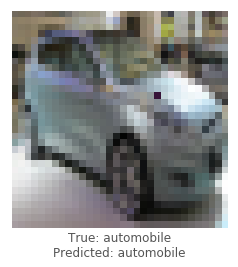

resnet - image 3402 - 22 / 100


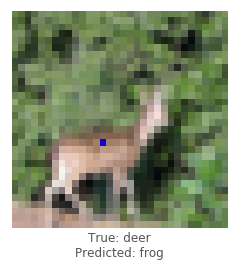

resnet - image 7029 - 23 / 100


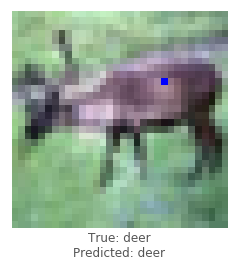

resnet - image 4408 - 24 / 100


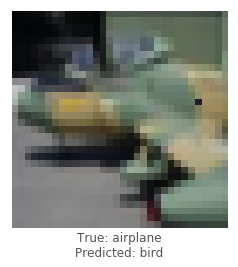

resnet - image 2168 - 25 / 100


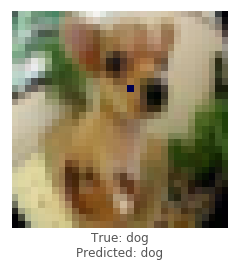

resnet - image 1864 - 26 / 100


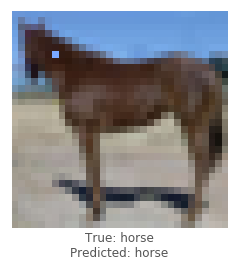

resnet - image 5713 - 27 / 100


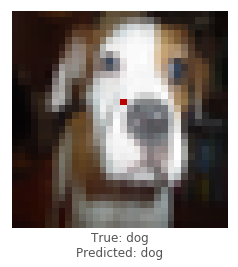

resnet - image 3166 - 28 / 100


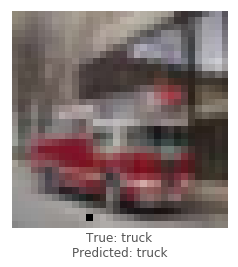

resnet - image 4531 - 29 / 100


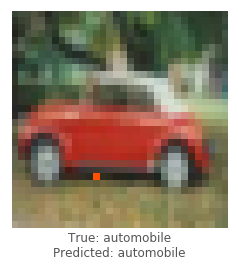

resnet - image 1144 - 30 / 100


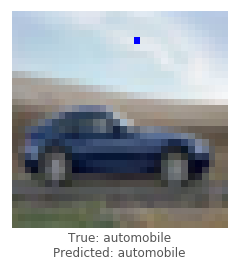

resnet - image 4479 - 31 / 100


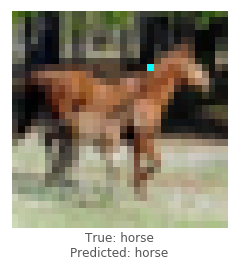

resnet - image 586 - 32 / 100


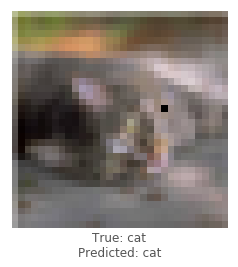

resnet - image 9782 - 33 / 100


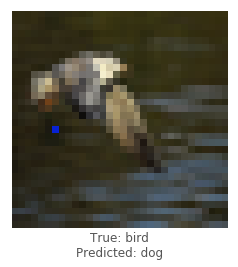

resnet - image 180 - 34 / 100


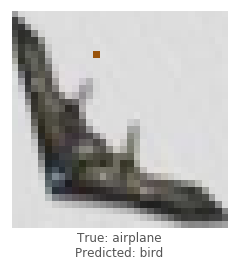

resnet - image 9003 - 35 / 100


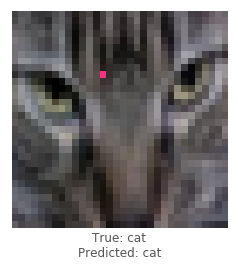

resnet - image 7076 - 36 / 100


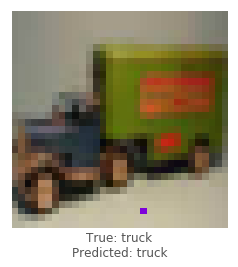

resnet - image 9441 - 37 / 100


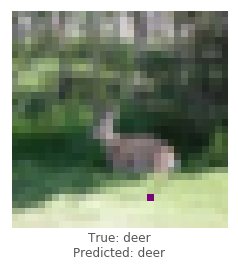

resnet - image 6259 - 38 / 100


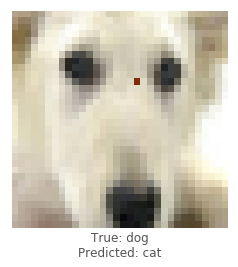

resnet - image 2969 - 39 / 100


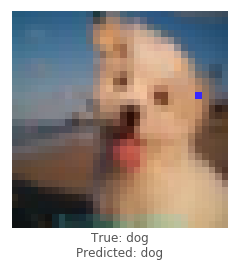

resnet - image 3156 - 40 / 100


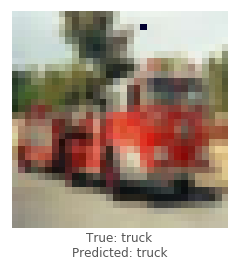

resnet - image 4313 - 41 / 100


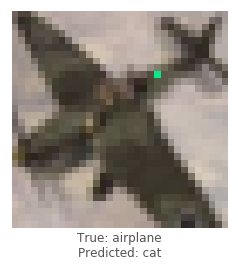

resnet - image 9596 - 42 / 100


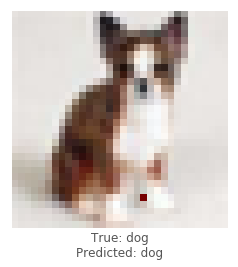

resnet - image 14 - 43 / 100


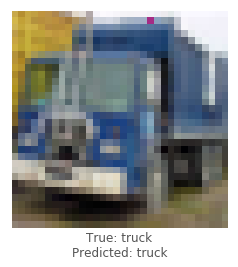

resnet - image 5834 - 44 / 100


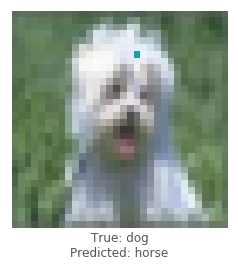

resnet - image 2980 - 45 / 100


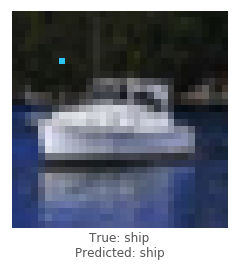

resnet - image 2069 - 46 / 100


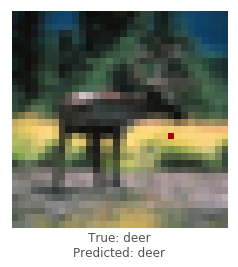

resnet - image 348 - 47 / 100


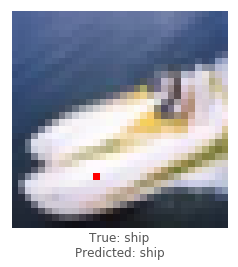

resnet - image 4015 - 48 / 100


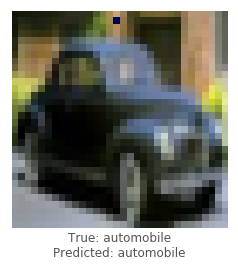

resnet - image 5968 - 49 / 100


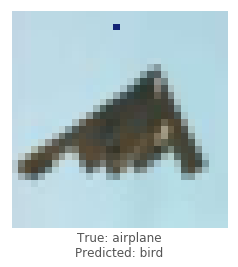

resnet - image 5794 - 50 / 100


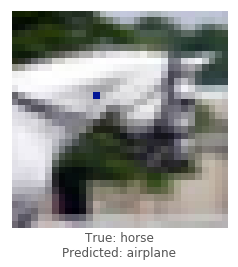

resnet - image 7501 - 51 / 100


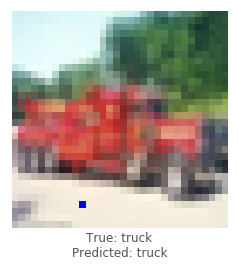

resnet - image 7721 - 52 / 100


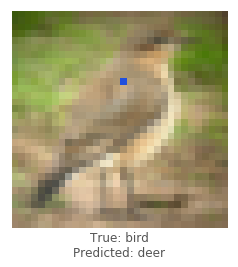

resnet - image 4361 - 53 / 100


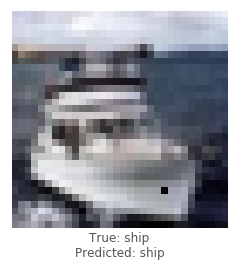

resnet - image 9651 - 54 / 100


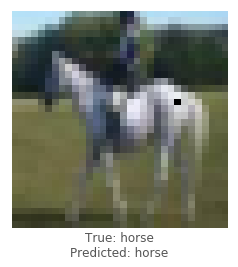

resnet - image 153 - 55 / 100


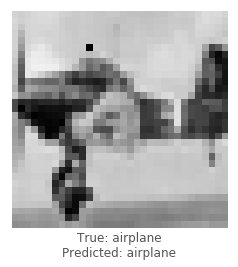

resnet - image 6109 - 56 / 100


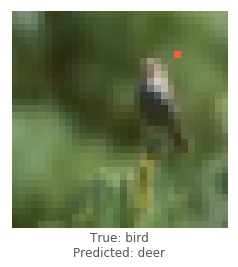

resnet - image 1604 - 57 / 100


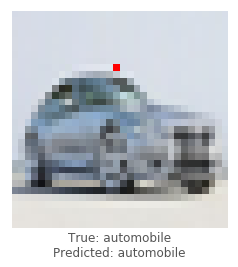

resnet - image 8333 - 58 / 100


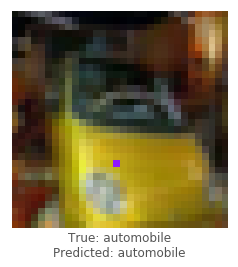

resnet - image 5105 - 59 / 100


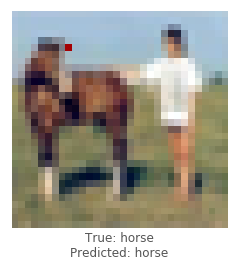

resnet - image 3303 - 60 / 100


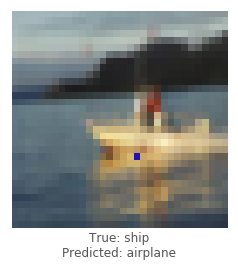

resnet - image 582 - 61 / 100


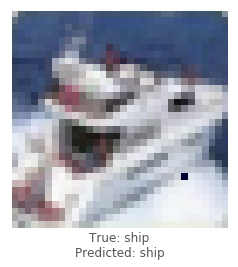

resnet - image 3427 - 62 / 100


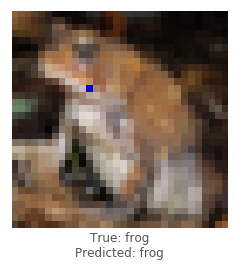

resnet - image 56 - 63 / 100


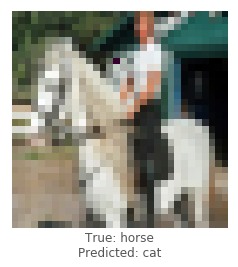

resnet - image 4489 - 64 / 100


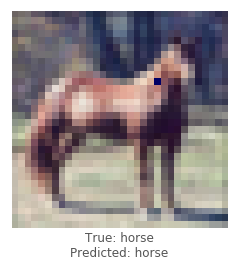

resnet - image 4650 - 65 / 100


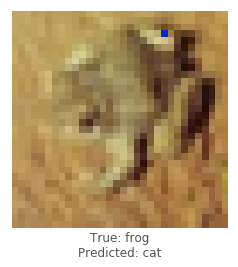

resnet - image 7478 - 66 / 100


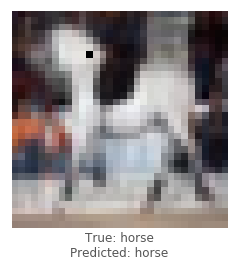

resnet - image 2813 - 67 / 100


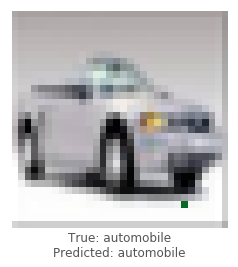

resnet - image 6329 - 68 / 100


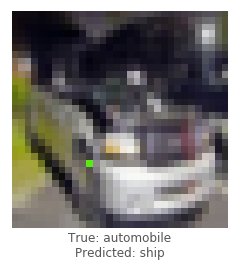

resnet - image 1989 - 69 / 100


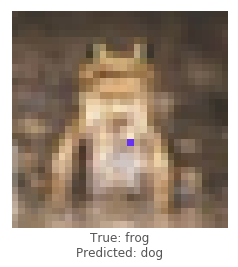

resnet - image 9735 - 70 / 100


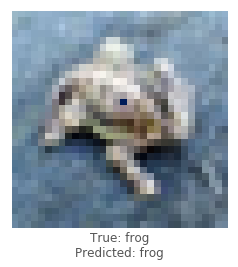

resnet - image 2295 - 71 / 100


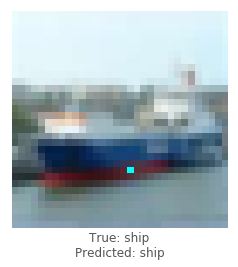

resnet - image 5420 - 72 / 100


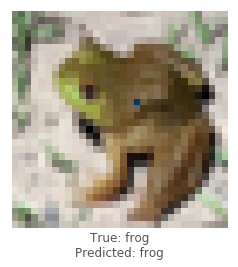

resnet - image 1319 - 73 / 100


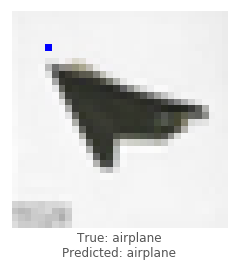

resnet - image 7141 - 74 / 100


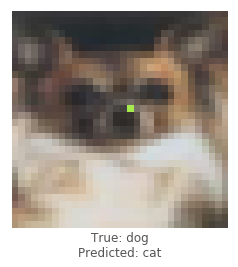

resnet - image 2978 - 75 / 100


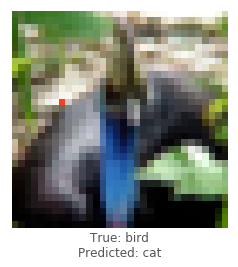

resnet - image 2723 - 76 / 100


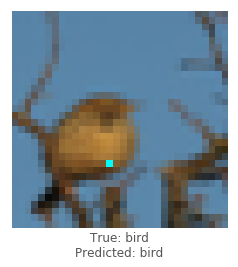

resnet - image 9031 - 77 / 100


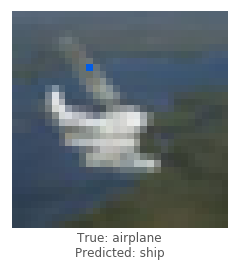

resnet - image 8675 - 78 / 100


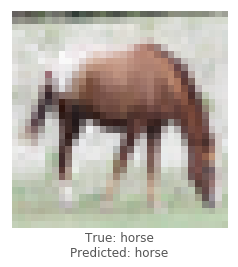

resnet - image 5055 - 79 / 100


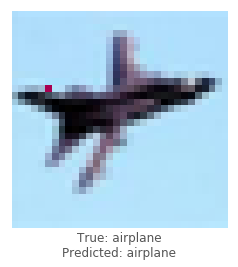

resnet - image 1352 - 80 / 100


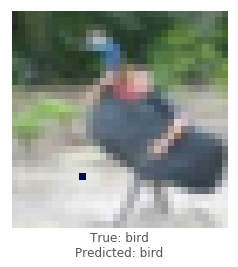

resnet - image 9546 - 81 / 100


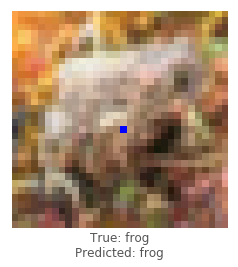

resnet - image 2041 - 82 / 100


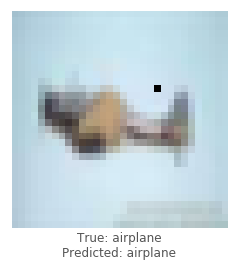

resnet - image 655 - 83 / 100


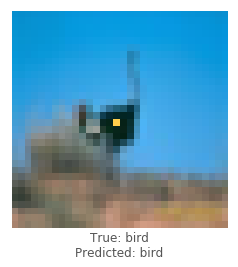

resnet - image 2546 - 84 / 100


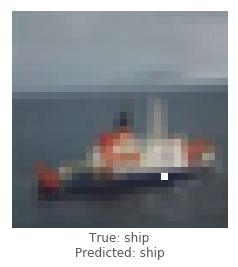

resnet - image 4459 - 85 / 100


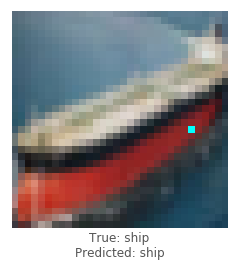

resnet - image 7694 - 86 / 100


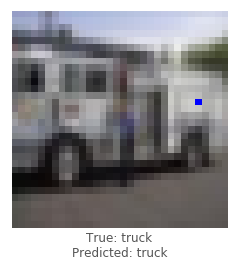

resnet - image 3915 - 87 / 100


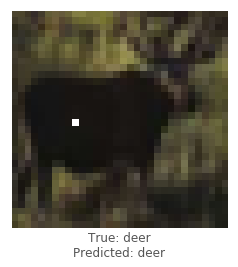

resnet - image 7145 - 88 / 100


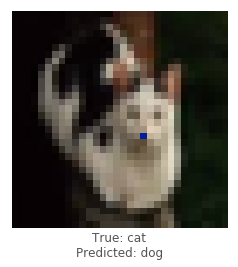

resnet - image 5723 - 89 / 100


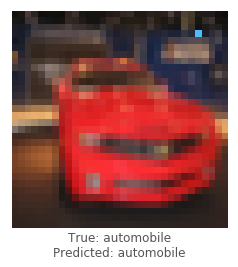

resnet - image 4157 - 90 / 100


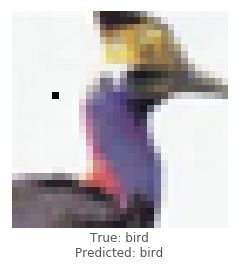

resnet - image 8196 - 91 / 100


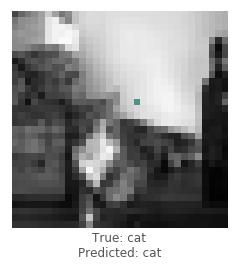

resnet - image 9410 - 92 / 100


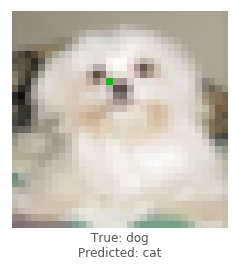

resnet - image 1696 - 93 / 100


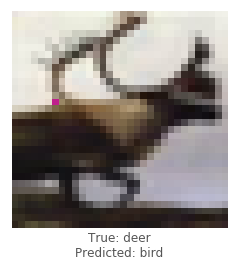

resnet - image 5333 - 94 / 100


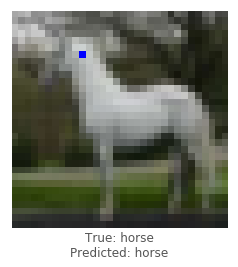

resnet - image 2504 - 95 / 100


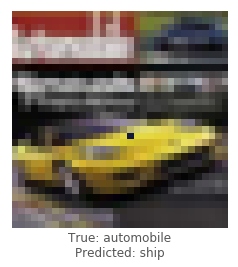

resnet - image 8350 - 96 / 100


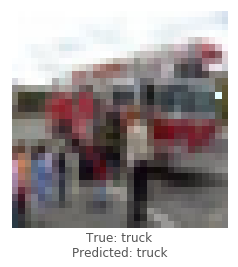

resnet - image 1859 - 97 / 100


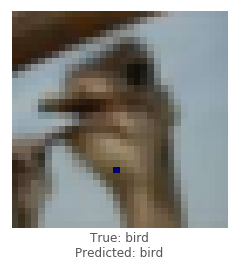

resnet - image 7344 - 98 / 100


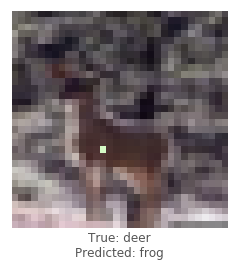

resnet - image 3858 - 99 / 100


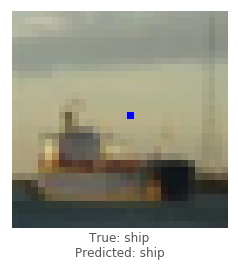

resnet - image 9310 - 100 / 100


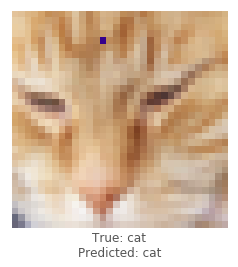

In [18]:
time_start=time()
untargeted = attack_all(models, samples=100, targeted=False)
time_end=time()

In [19]:
untargeted_time=time_end-time_start
print(untargeted_time)

4412.835656881332


lecun_net - image 4816 - 1 / 10
Attacking with target airplane


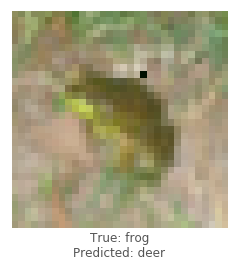

Attacking with target automobile


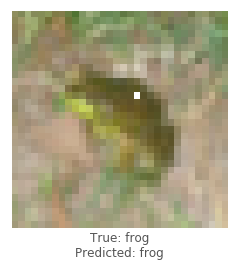

Attacking with target bird


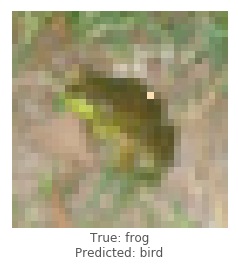

Attacking with target cat


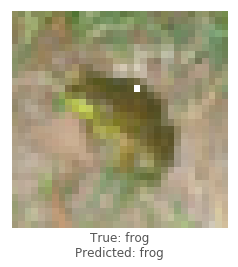

Attacking with target deer


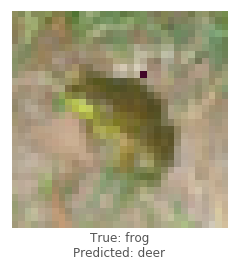

Attacking with target dog


/media/shanicky/HDD/code/one-pixel-attack-keras/differential_evolution.py:584: RuntimeWarning: divide by zero encountered in double_scalars
  convergence=self.tol / convergence) is True):


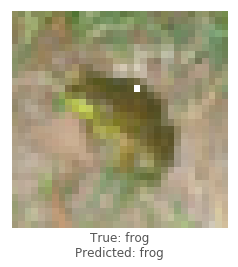

Attacking with target frog
Attacking with target horse


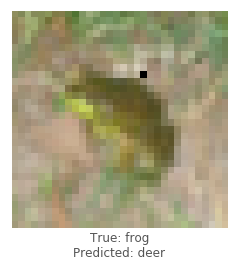

Attacking with target ship


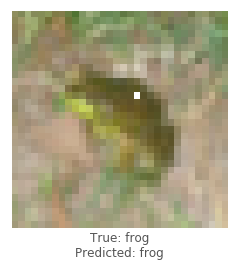

Attacking with target truck


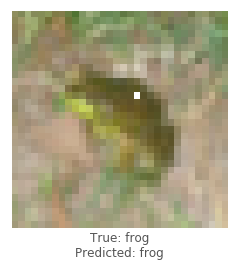

lecun_net - image 6597 - 2 / 10
Attacking with target airplane


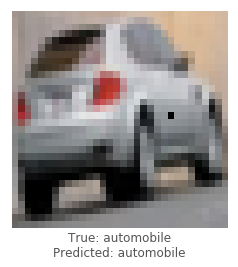

Attacking with target automobile
Attacking with target bird


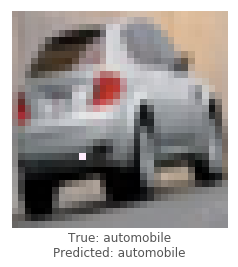

Attacking with target cat


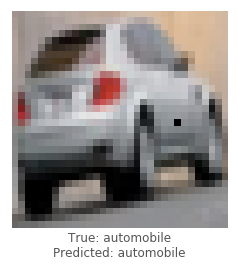

Attacking with target deer


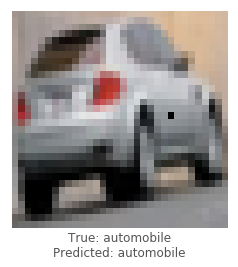

Attacking with target dog


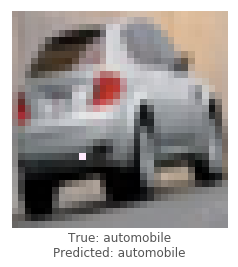

Attacking with target frog


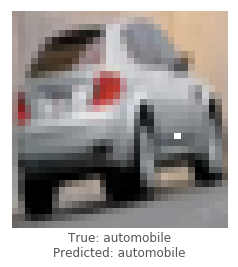

Attacking with target horse


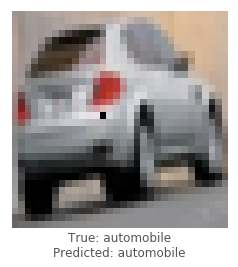

Attacking with target ship


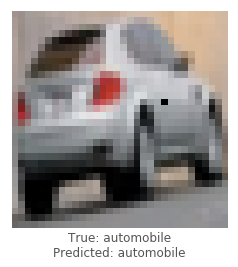

Attacking with target truck


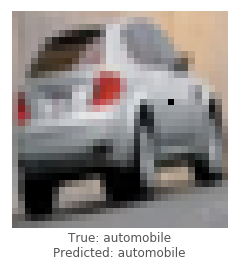

lecun_net - image 1846 - 3 / 10
Attacking with target airplane


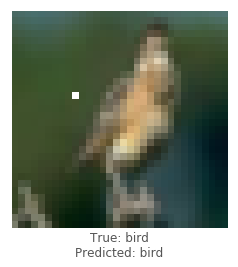

Attacking with target automobile


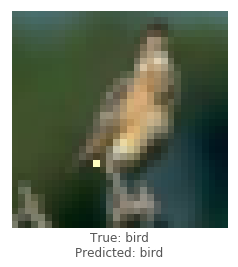

Attacking with target bird
Attacking with target cat


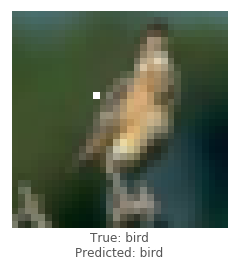

Attacking with target deer


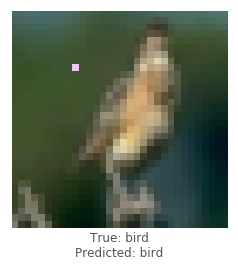

Attacking with target dog


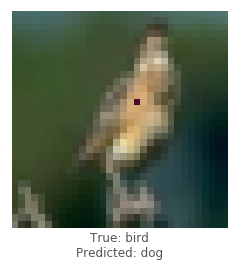

Attacking with target frog


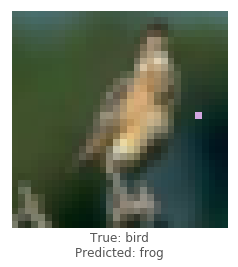

Attacking with target horse


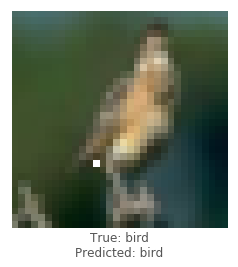

Attacking with target ship


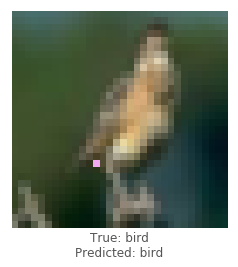

Attacking with target truck


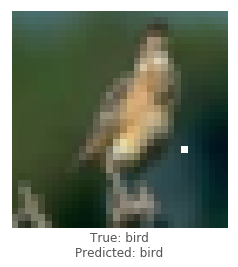

lecun_net - image 5595 - 4 / 10
Attacking with target airplane


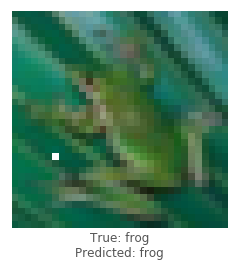

Attacking with target automobile


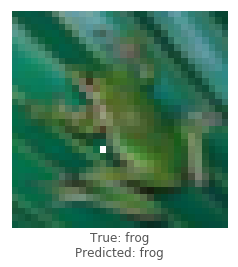

Attacking with target bird


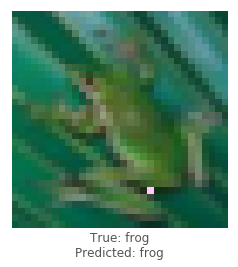

Attacking with target cat


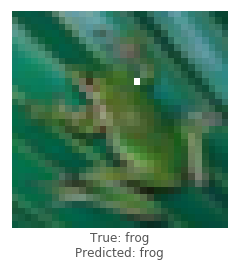

Attacking with target deer


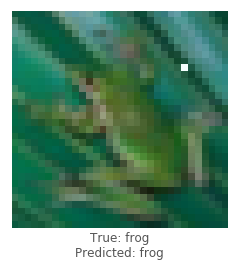

Attacking with target dog


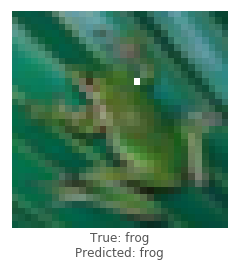

Attacking with target frog
Attacking with target horse


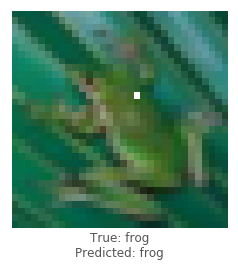

Attacking with target ship


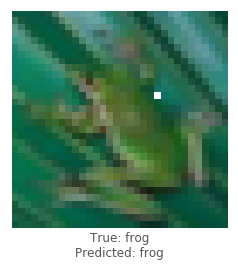

Attacking with target truck


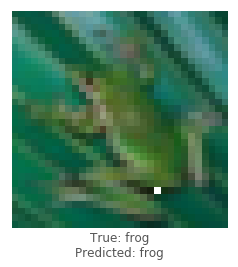

lecun_net - image 5791 - 5 / 10
Attacking with target airplane


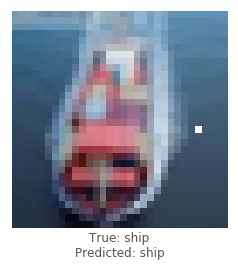

Attacking with target automobile


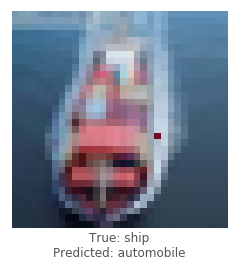

Attacking with target bird


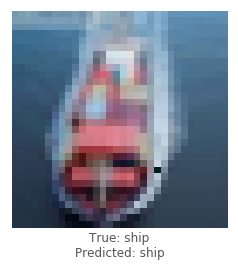

Attacking with target cat


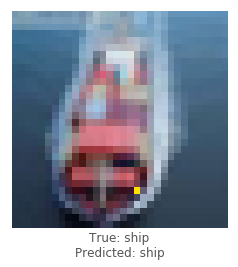

Attacking with target deer


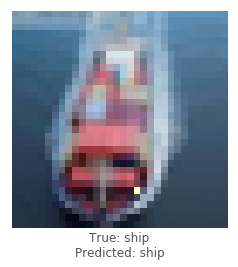

Attacking with target dog


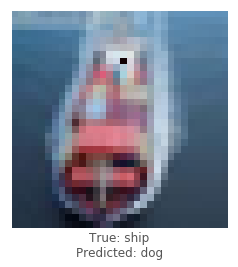

Attacking with target frog


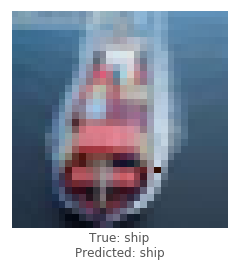

Attacking with target horse


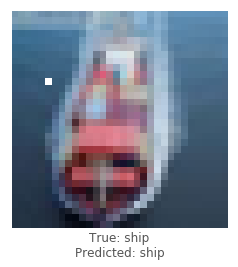

Attacking with target ship
Attacking with target truck


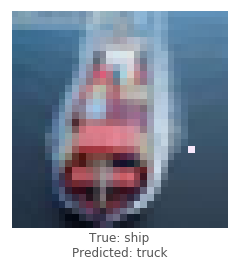

lecun_net - image 4199 - 6 / 10
Attacking with target airplane


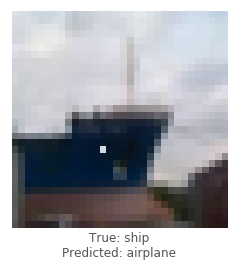

Attacking with target automobile


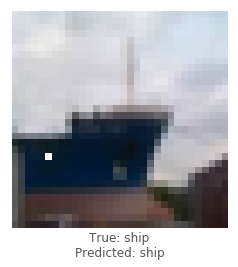

Attacking with target bird


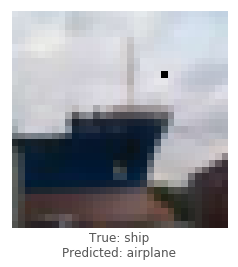

Attacking with target cat


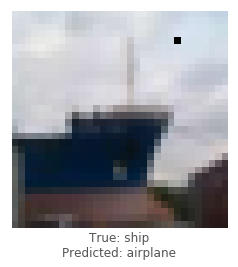

Attacking with target deer


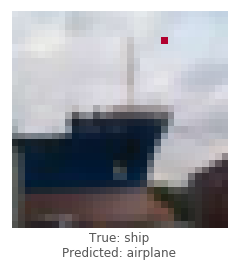

Attacking with target dog


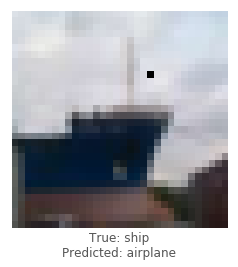

Attacking with target frog


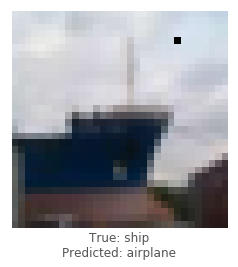

Attacking with target horse


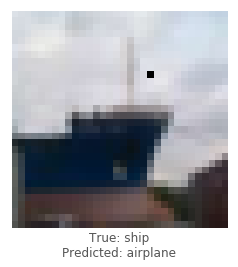

Attacking with target ship
Attacking with target truck


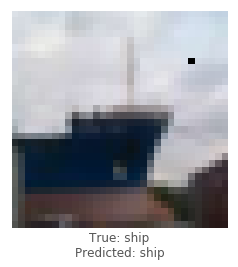

lecun_net - image 4151 - 7 / 10
Attacking with target airplane


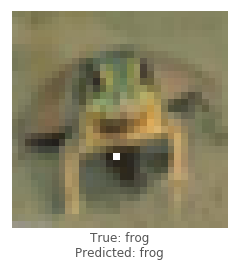

Attacking with target automobile


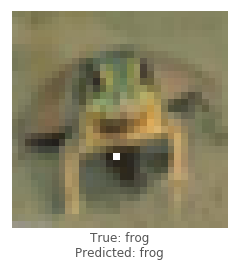

Attacking with target bird


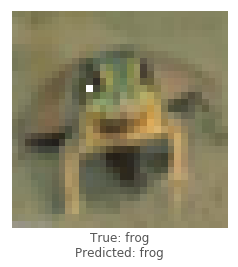

Attacking with target cat


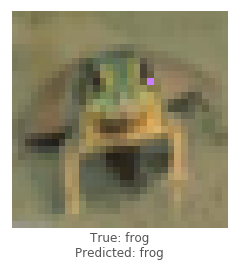

Attacking with target deer


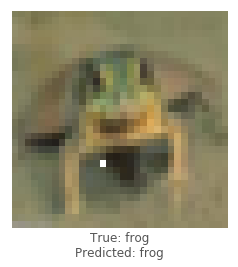

Attacking with target dog


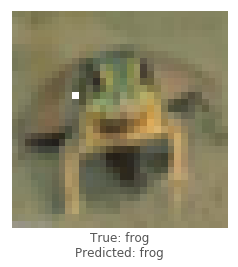

Attacking with target frog
Attacking with target horse


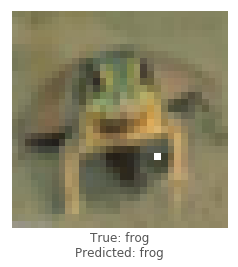

Attacking with target ship


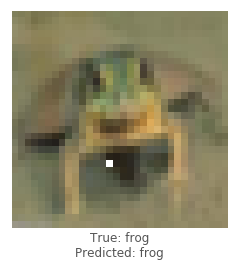

Attacking with target truck


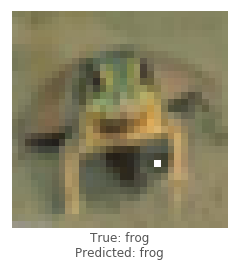

lecun_net - image 2424 - 8 / 10
Attacking with target airplane


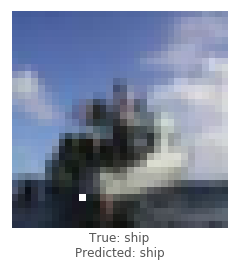

Attacking with target automobile


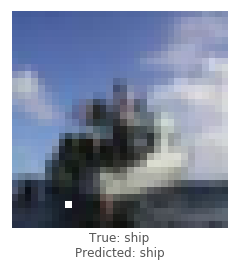

Attacking with target bird


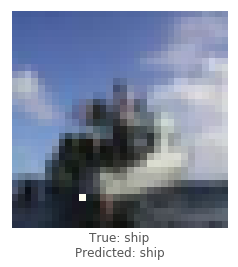

Attacking with target cat


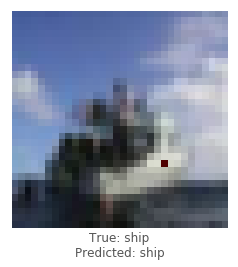

Attacking with target deer


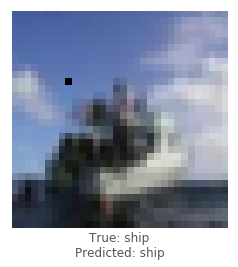

Attacking with target dog


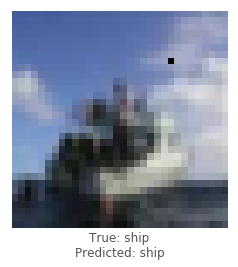

Attacking with target frog


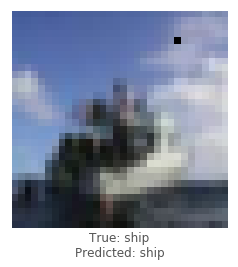

Attacking with target horse


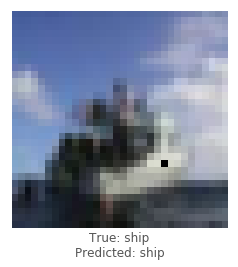

Attacking with target ship
Attacking with target truck


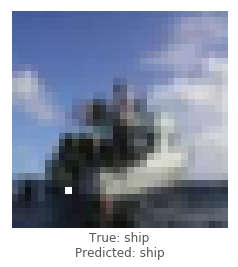

lecun_net - image 5673 - 9 / 10
Attacking with target airplane


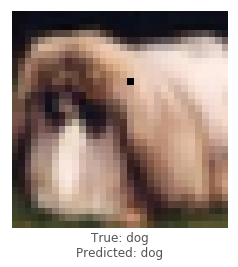

Attacking with target automobile


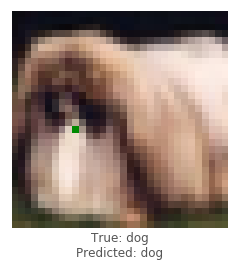

Attacking with target bird


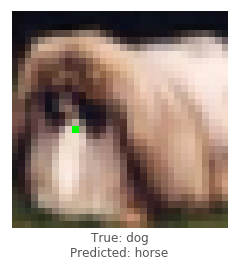

Attacking with target cat


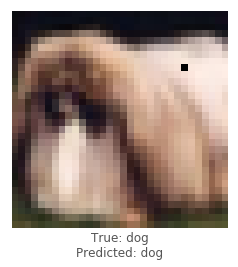

Attacking with target deer


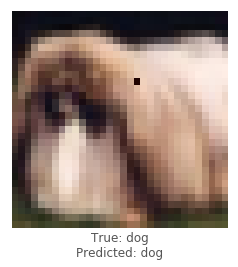

Attacking with target dog
Attacking with target frog


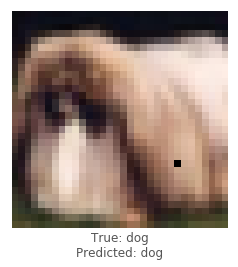

Attacking with target horse


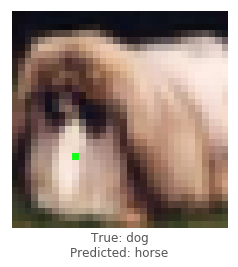

Attacking with target ship


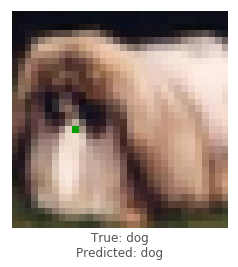

Attacking with target truck


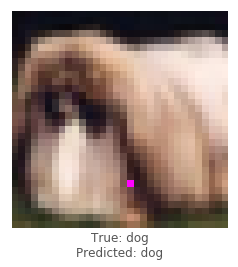

lecun_net - image 6333 - 10 / 10
Attacking with target airplane


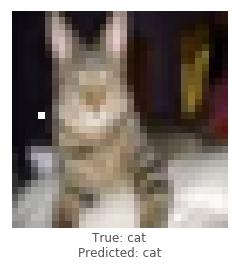

Attacking with target automobile


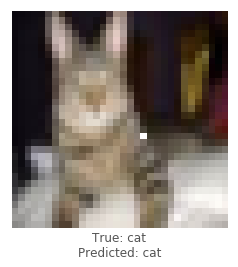

Attacking with target bird


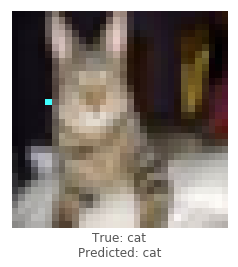

Attacking with target cat
Attacking with target deer


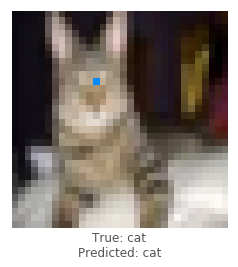

Attacking with target dog


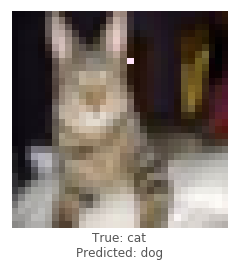

Attacking with target frog


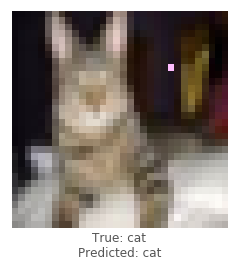

Attacking with target horse


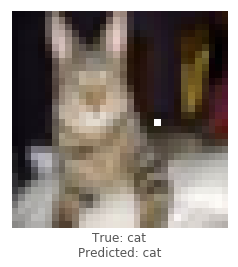

Attacking with target ship


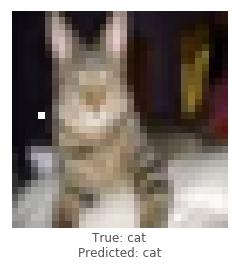

Attacking with target truck


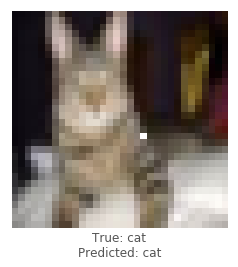

resnet - image 875 - 1 / 10
Attacking with target airplane


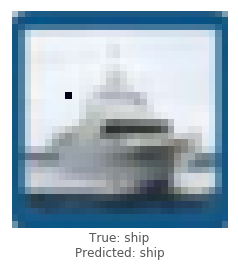

Attacking with target automobile


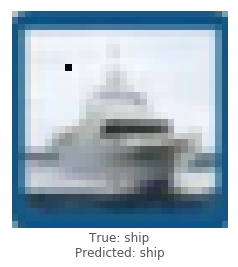

Attacking with target bird


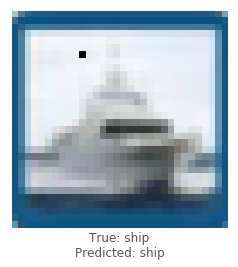

Attacking with target cat


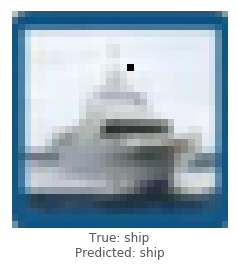

Attacking with target deer


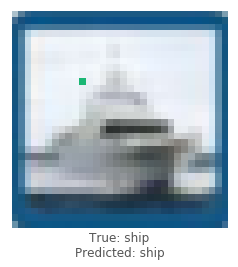

Attacking with target dog


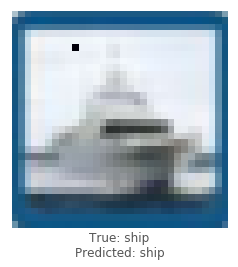

Attacking with target frog


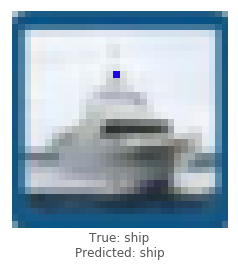

Attacking with target horse


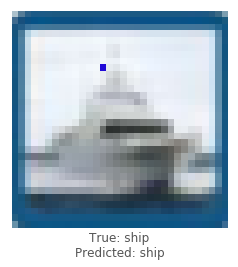

Attacking with target ship
Attacking with target truck


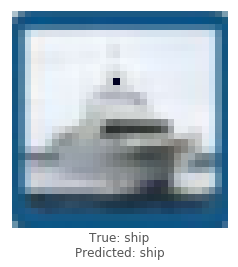

resnet - image 2325 - 2 / 10
Attacking with target airplane


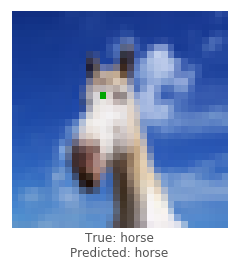

Attacking with target automobile


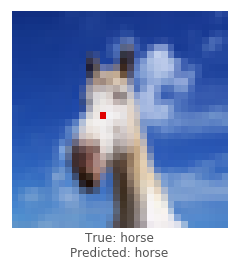

Attacking with target bird


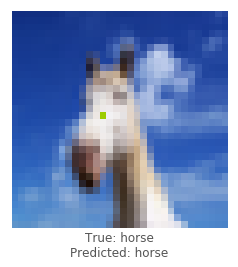

Attacking with target cat


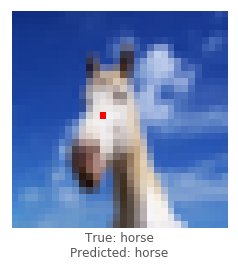

Attacking with target deer


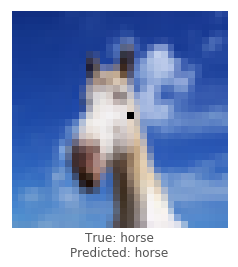

Attacking with target dog


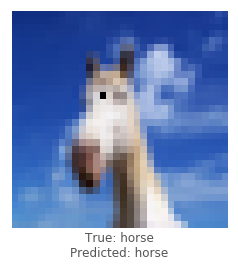

Attacking with target frog


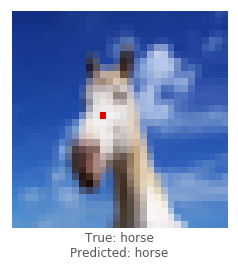

Attacking with target horse
Attacking with target ship


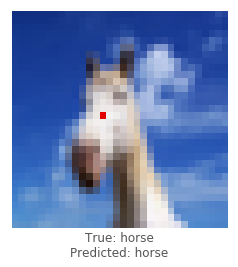

Attacking with target truck


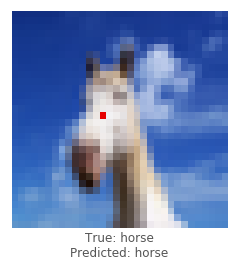

resnet - image 6220 - 3 / 10
Attacking with target airplane


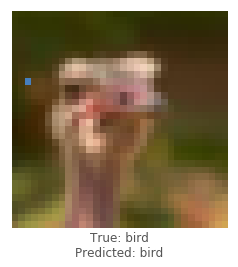

Attacking with target automobile


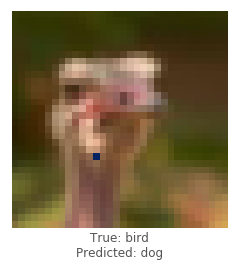

Attacking with target bird
Attacking with target cat


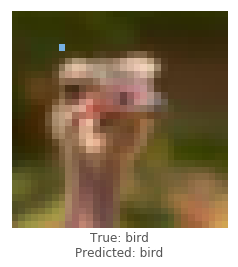

Attacking with target deer


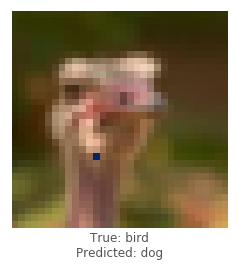

Attacking with target dog


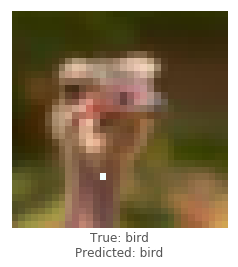

Attacking with target frog


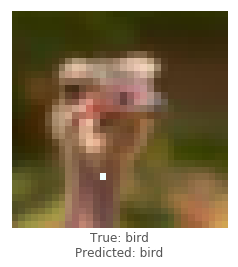

Attacking with target horse


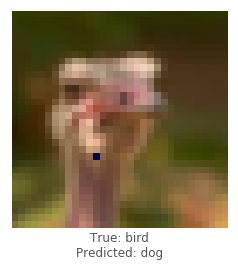

Attacking with target ship


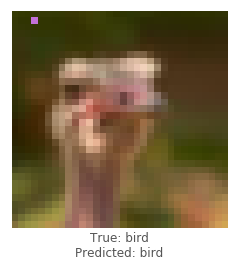

Attacking with target truck


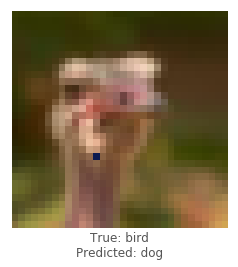

resnet - image 6938 - 4 / 10
Attacking with target airplane


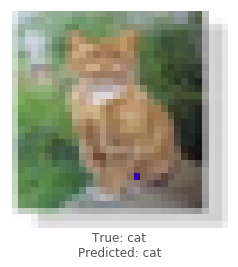

Attacking with target automobile


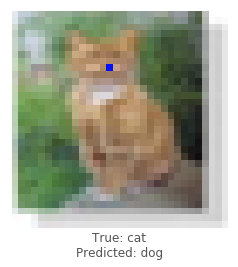

Attacking with target bird


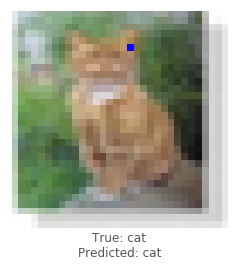

Attacking with target cat
Attacking with target deer


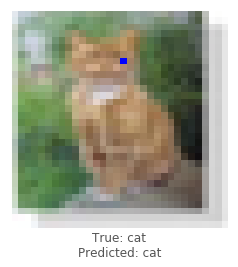

Attacking with target dog


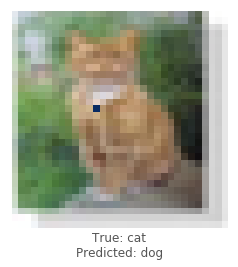

Attacking with target frog


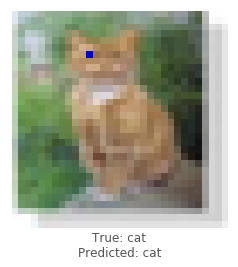

Attacking with target horse


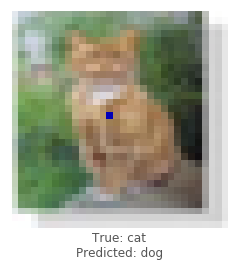

Attacking with target ship


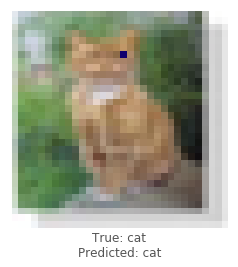

Attacking with target truck


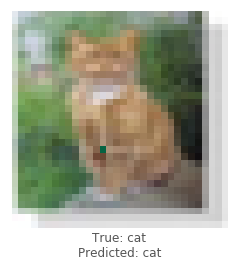

resnet - image 6322 - 5 / 10
Attacking with target airplane


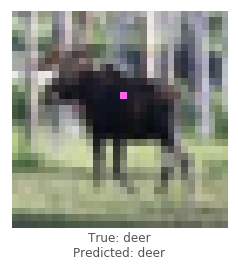

Attacking with target automobile


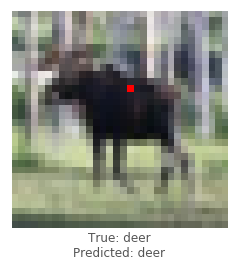

Attacking with target bird


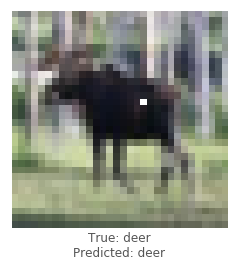

Attacking with target cat


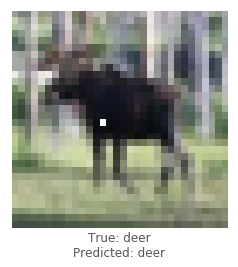

Attacking with target deer
Attacking with target dog


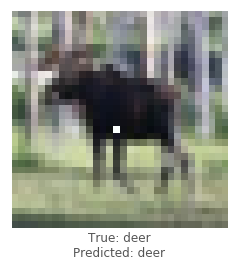

Attacking with target frog


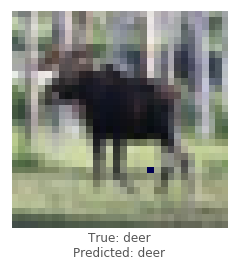

Attacking with target horse


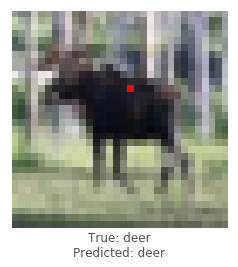

Attacking with target ship


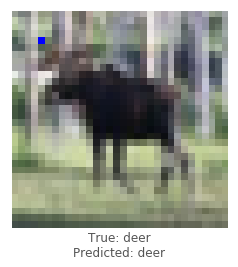

Attacking with target truck


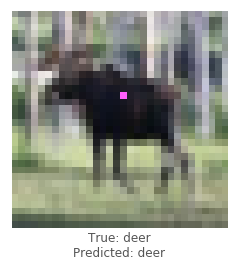

resnet - image 3282 - 6 / 10
Attacking with target airplane


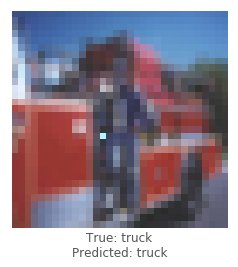

Attacking with target automobile


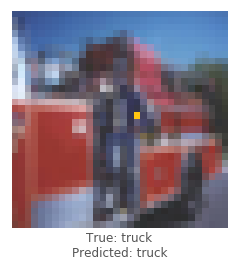

Attacking with target bird


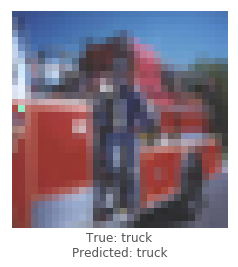

Attacking with target cat


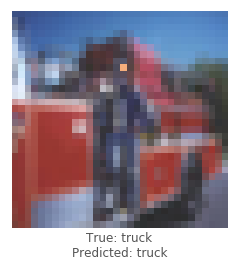

Attacking with target deer


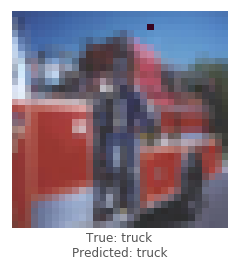

Attacking with target dog


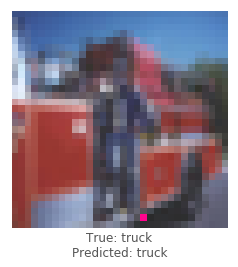

Attacking with target frog


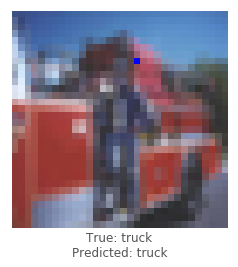

Attacking with target horse


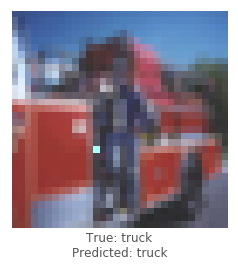

Attacking with target ship


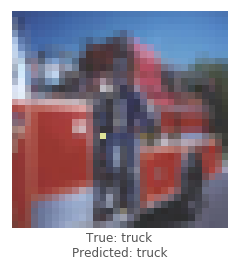

Attacking with target truck
resnet - image 2946 - 7 / 10
Attacking with target airplane


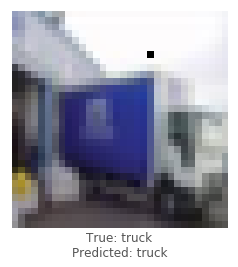

Attacking with target automobile


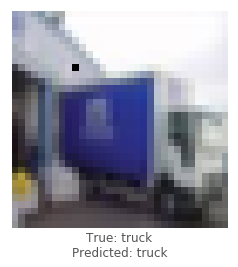

Attacking with target bird


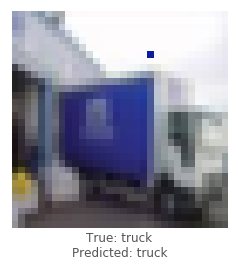

Attacking with target cat


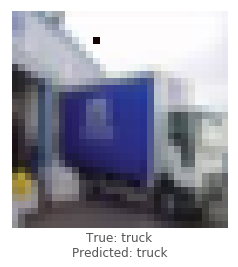

Attacking with target deer


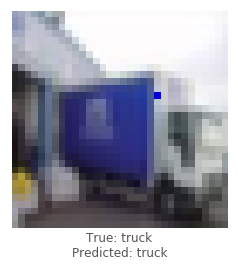

Attacking with target dog


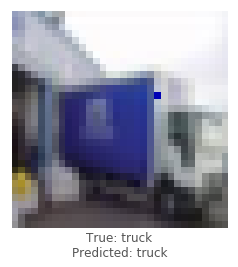

Attacking with target frog


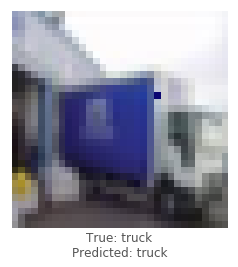

Attacking with target horse


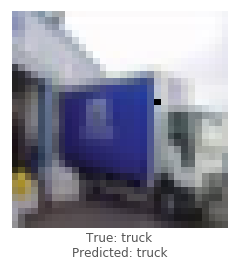

Attacking with target ship


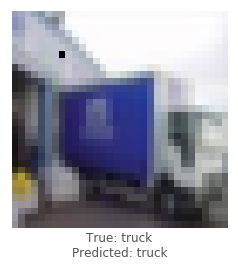

Attacking with target truck
resnet - image 4336 - 8 / 10
Attacking with target airplane


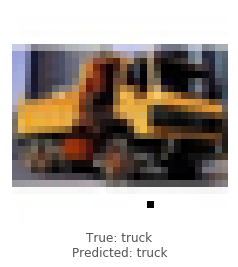

Attacking with target automobile


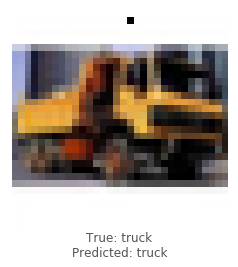

Attacking with target bird


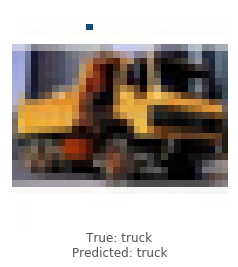

Attacking with target cat


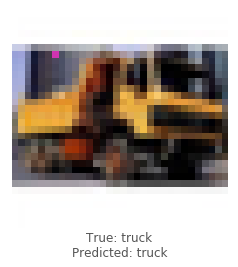

Attacking with target deer


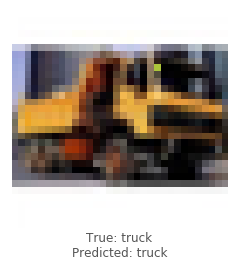

Attacking with target dog


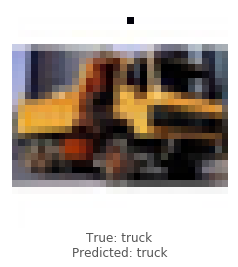

Attacking with target frog


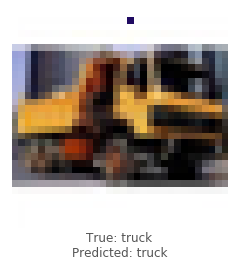

Attacking with target horse


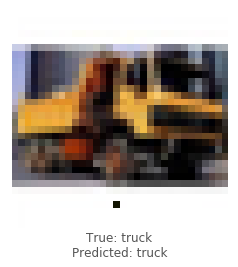

Attacking with target ship


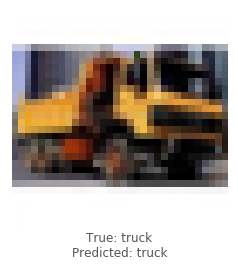

Attacking with target truck
resnet - image 9210 - 9 / 10
Attacking with target airplane


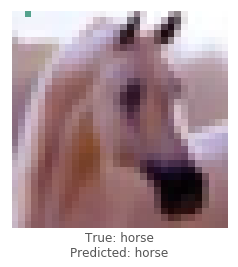

Attacking with target automobile


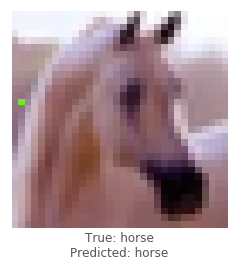

Attacking with target bird


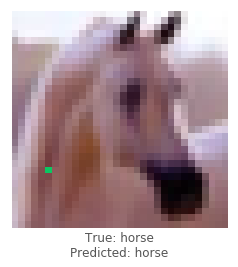

Attacking with target cat


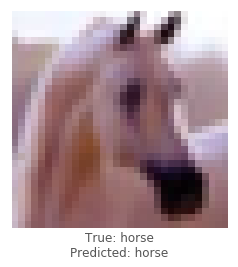

Attacking with target deer


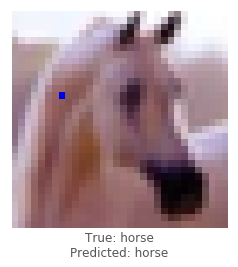

Attacking with target dog


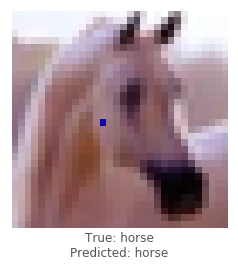

Attacking with target frog


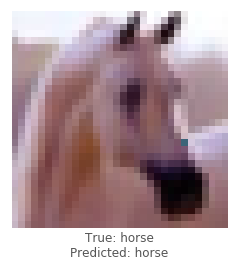

Attacking with target horse
Attacking with target ship


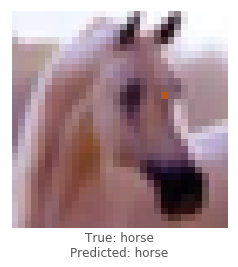

Attacking with target truck


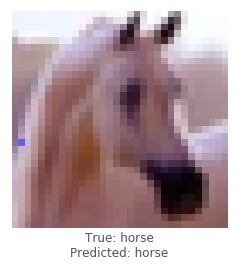

resnet - image 3549 - 10 / 10
Attacking with target airplane


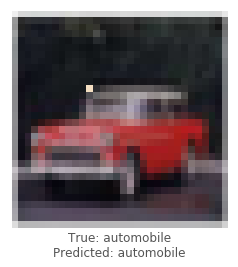

Attacking with target automobile
Attacking with target bird


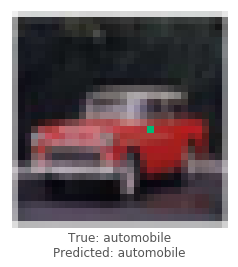

Attacking with target cat


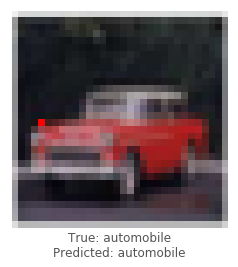

Attacking with target deer


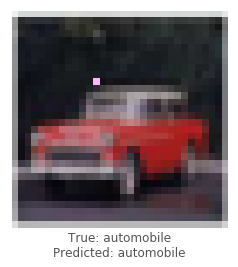

Attacking with target dog


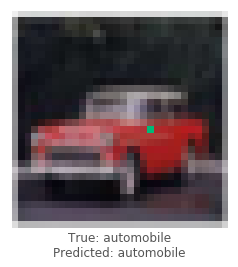

Attacking with target frog


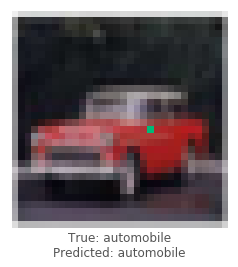

Attacking with target horse


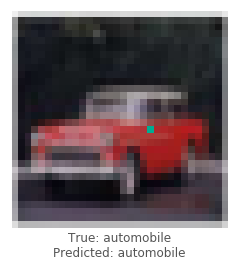

Attacking with target ship


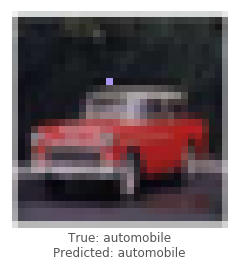

Attacking with target truck


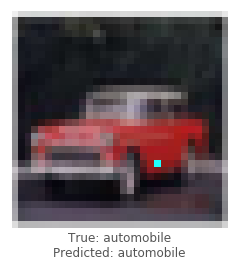

In [20]:
time_start=time()
targeted = attack_all(models, samples=10, targeted=True)
time_end=time()

In [21]:
targeted_time=time_end-time_start
print(targeted_time)

5304.737694978714


### Attack Statistics

Print the final results! 

In [22]:
# Load the results
untargeted, targeted = helper.load_results()

In [23]:
columns = ['model', 'pixels', 'image', 'true', 'predicted', 'success', 'cdiff', 'prior_probs', 'predicted_probs', 'perturbation']
untargeted_results = pd.DataFrame(untargeted, columns=columns)
targeted_results = pd.DataFrame(targeted, columns=columns)

#### Untargeted

In [24]:
helper.attack_stats(untargeted_results, models, network_stats)

,model,accuracy,pixels,attack_success_rate
0,lecun_net,0.7488,1,0.53
1,resnet,0.9231,1,0.29


#### Targeted

In [25]:
helper.attack_stats(targeted_results, models, network_stats)

,model,accuracy,pixels,attack_success_rate
0,lecun_net,0.7488,1,0.211111
1,resnet,0.9231,1,0.077778


### Show some successful attacks

Plot 9 random successful attack images

Untargeted Attack


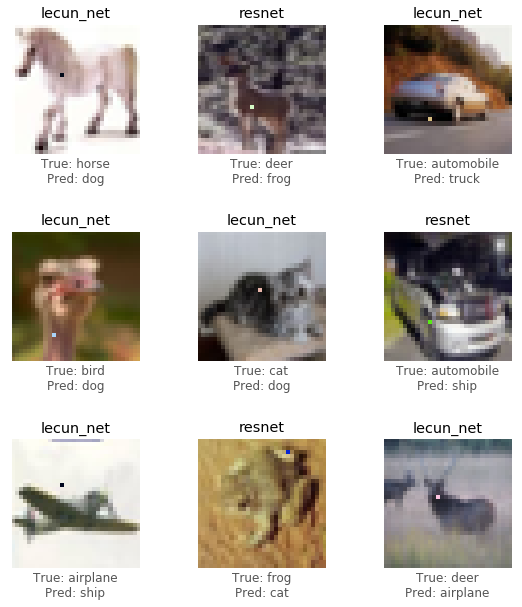

In [26]:
print('Untargeted Attack')
helper.visualize_attack(untargeted_results, class_names)

Targeted Attack


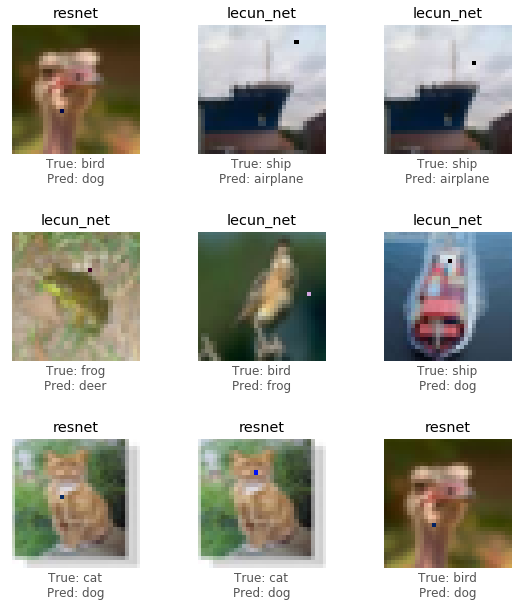

In [27]:
print('Targeted Attack')
helper.visualize_attack(targeted_results, class_names)

## Conclusions

It appears that the accuracy of a model is not strongly correlated with the chance of performing a successful attack on an image. Perhaps surprisingly, the purely convolutional model is the most resistant CNN to these types of attacks. In addition, the capsule network CapsNet has the lowest attack success rate out of all the models, although it is still vulnerable to attack.

## Credits
 -  This implemenation is based off of the original paper describing the one pixel attack: https://arxiv.org/abs/1710.08864
 - Base code for iPython notebook: https://github.com/09rohanchopra/cifar10
 - Keras Cifar10 models: https://github.com/BIGBALLON/cifar-10-cnn
 - Scipy's differential evolution implementation: https://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.optimize.differential_evolution.html
 - State of the art: https://github.com/RedditSota/state-of-the-art-result-for-machine-learning-problems
 - CapsNet Keras: https://github.com/XifengGuo/CapsNet-Keras
 - CapsNet with Cifar: https://github.com/theblackcat102/dynamic-routing-capsule-cifar